
# 🏪 Store Sales Time Series Forecasting 📈

### [1. Introduction](#1-introduction)
#### [1.1. Problem Statement](#11-problem-statement)
#### 1.2. Data Description
#### 1.3. Objective
### 2. Data Exploration
#### 2.1. Importing Libraries
#### 2.2. Loading Data
#### 2.3. Data Exploration
##### 2.3.1. Univariant Analysis
##### 2.3.2. Bivariant Analysis
##### 2.3.3. Multivariant Analysis
### 3. Data Preprocessing
#### 3.1. Data Cleaning
#### 3.2. Data Transformation
#### 3.3. Data Preparation
### 4. Feature Engineering
### 5. Model Building
#### 5.1. Baseline Model
### 6. Model Evaluation


## 1. Introduction

### 1.1. Problem Statement

We have a dataset of Favorita stores located in Ecuador, we need to predict the sales of thousands of product families sold at thses stores. The training data includes dates, store and product information, whether that item was being promoted, as well as the sales numbers. Additional files include supplementary information that may be useful in building our models.

### 1.2. Data Description

> **train.csv**
>
> * The training data, comprising time series of features **store_nbr**, **family**, and **onpromotion** as well as the target **sales**.
>
> * **store_nbr** identifies the store at which the products are sold.
>
> * **family** identifies the type of product sold.
>
> * **sales** gives the total sales for a product family at a particular store at a given date. Fractional values are possible since products can be sold in fractional units (1.5 kg of cheese, for instance, as opposed to 1 bag of chips).
>
> * **onpromotion** gives the total number of items in a product family that were being promoted at a store at a given date.


> **test.csv**
>
> * The test data, having the same features as the training data. You will predict the target **sales** for the dates in this file.
>
> * The dates in the test data are for the 15 days after the last date in the training data.


> **stores.csv**
>
> * Store metadata, including **city**, **state**, **type**, and **cluster**.
>
> * **cluster** is a grouping of similar stores.


> **oil.csv**
>
> * Daily oil price. Includes values during both the train and test data timeframes. (Ecuador is an oil-dependent country and it's economical health is highly vulnerable to shocks in oil prices.)


> **holidays_events.csv**
>
> * Holidays and Events, with metadata
>
> * NOTE: Pay special attention to the transferred column. A holiday that is transferred officially falls on that calendar day, but was moved to another date by the government. A transferred day is more like a normal day than a holiday. To find the day that it was actually celebrated, look for the corresponding row where type is Transfer. For example, the holiday Independencia de Guayaquil was transferred from 2012-10-09 to 2012-10-12, which means it was celebrated on 2012-10-12. Days that are type Bridge are extra days that are added to a holiday (e.g., to extend the break across a long weekend). These are frequently made up by the type Work Day which is a day not normally scheduled for work (e.g., Saturday) that is meant to payback the Bridge.
>
> * Additional holidays are days added a regular calendar holiday, for example, as typically happens around Christmas (making Christmas Eve a holiday).


> **transactions.csv**
>
> * It contains **date**, **store_nbr**, **transactions**. Where **transactions** is the count of sales transactions at the store for the day.


**Additional Notes**
* Wages in the public sector are paid every two weeks on the 15 th and on the last day of the month. Supermarket sales could be affected by this.
* A magnitude 7.8 earthquake struck Ecuador on April 16, 2016. People rallied in relief efforts donating water and other first need products which greatly affected supermarket sales for several weeks after the earthquake.

### 1.3. Objective

## 2. Data Exploration

### 2.1. Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import datetime
import os
import warnings

sns.set_context('notebook', font_scale=1.5)
warnings.filterwarnings('ignore')

### 2.2. Loading Data

In [2]:
# Let see what data we have
print(os.listdir("../../input/store_sales_time_series_forecasting/"))

['sample_submission.csv', 'test.csv', 'train.csv', 'holidays_events.csv', 'stores.csv', 'oil.csv', 'transactions.csv', 'train_merged.csv']


In [168]:
train = pd.read_csv('../../input/store_sales_time_series_forecasting/train.csv')
test = pd.read_csv('../../input/store_sales_time_series_forecasting/test.csv')
sample_submission = pd.read_csv('../../input/store_sales_time_series_forecasting/sample_submission.csv')
holidays = pd.read_csv('../../input/store_sales_time_series_forecasting/holidays_events.csv')
oil_price = pd.read_csv('../../input/store_sales_time_series_forecasting/oil.csv')
stores = pd.read_csv('../../input/store_sales_time_series_forecasting/stores.csv')
transactions = pd.read_csv('../../input/store_sales_time_series_forecasting/transactions.csv')

### 2.3. Data Exploration

In [169]:
# Lets check the shape of these datasets
shapes = pd.DataFrame({'train': train.shape, 
                       'test': test.shape, 
                       'sample_submission': sample_submission.shape, 
                       'holidays': holidays.shape, 
                       'oil_price': oil_price.shape, 
                       'stores': stores.shape,
                       'transactions': transactions.shape}, index=['rows', 'columns'])
shapes

train   test  sample_submission  holidays  oil_price  stores  \
rows     3000888  28512              28512       350       1218      54   
columns        6      5                  2         6          2       5   

         transactions  
rows            83488  
columns             3

In [170]:
# Let's explore what's inside these datasets
train.head()

id        date  store_nbr      family  sales  onpromotion
0   0  2013-01-01          1  AUTOMOTIVE    0.0            0
1   1  2013-01-01          1   BABY CARE    0.0            0
2   2  2013-01-01          1      BEAUTY    0.0            0
3   3  2013-01-01          1   BEVERAGES    0.0            0
4   4  2013-01-01          1       BOOKS    0.0            0

In [171]:
train.dtypes

id               int64
date            object
store_nbr        int64
family          object
sales          float64
onpromotion      int64
dtype: object

* id column is adding no information we can drop it.
* date column need to be converted to datetime format.
* family is category of the items, we will convert this column to categorical type.


In [172]:
stores.head()

store_nbr           city                           state type  cluster
0          1          Quito                       Pichincha    D       13
1          2          Quito                       Pichincha    D       13
2          3          Quito                       Pichincha    D        8
3          4          Quito                       Pichincha    D        9
4          5  Santo Domingo  Santo Domingo de los Tsachilas    D        4

In [173]:
stores.dtypes

store_nbr     int64
city         object
state        object
type         object
cluster       int64
dtype: object

* we will combine this data with train on **store_nbr** column.
* **city**, **state**, **type** and **cluster** are categorical columns, we will convert them to categorical type.

In [174]:
transactions.tail()

date  store_nbr  transactions
83483  2017-08-15         50          2804
83484  2017-08-15         51          1573
83485  2017-08-15         52          2255
83486  2017-08-15         53           932
83487  2017-08-15         54           802

In [175]:
transactions.dtypes

date            object
store_nbr        int64
transactions     int64
dtype: object

* **date**, column need to be converted to datetime format.
* we will combine this data with train on **date** and **store_nbr** columns.

In [176]:
holidays.tail()

date        type    locale locale_name description  transferred
345  2017-12-22  Additional  National     Ecuador   Navidad-3        False
346  2017-12-23  Additional  National     Ecuador   Navidad-2        False
347  2017-12-24  Additional  National     Ecuador   Navidad-1        False
348  2017-12-25     Holiday  National     Ecuador     Navidad        False
349  2017-12-26  Additional  National     Ecuador   Navidad+1        False

In [177]:
holidays.dtypes

date           object
type           object
locale         object
locale_name    object
description    object
transferred      bool
dtype: object

* **date** column need to be converted to datetime format.
* **type**, **locale** and **locale_name** are categorical columns, we will convert them to categorical type.
* we will combine this data with train on **date** column.

In [178]:
oil_price.tail()

date  dcoilwtico
1213  2017-08-25       47.65
1214  2017-08-28       46.40
1215  2017-08-29       46.46
1216  2017-08-30       45.96
1217  2017-08-31       47.26

In [179]:
oil_price.dtypes

date           object
dcoilwtico    float64
dtype: object

In [180]:
test.tail()

id        date  store_nbr                      family  onpromotion
28507  3029395  2017-08-31          9                     POULTRY            1
28508  3029396  2017-08-31          9              PREPARED FOODS            0
28509  3029397  2017-08-31          9                     PRODUCE            1
28510  3029398  2017-08-31          9  SCHOOL AND OFFICE SUPPLIES            9
28511  3029399  2017-08-31          9                     SEAFOOD            0

In [181]:
sample_submission.tail()

id  sales
28507  3029395    0.0
28508  3029396    0.0
28509  3029397    0.0
28510  3029398    0.0
28511  3029399    0.0

* **date** column need to be converted to datetime format.
* we will combine this data with train on **date** column.

Let's to required type conversion and processing in all the datasets before merging them

In [182]:
# train:
train.drop('id', axis=1, inplace=True)
train.shape

(3000888, 5)

In [183]:
# train:
train['date'] = pd.to_datetime(train['date'])

# transactions:
transactions['date'] = pd.to_datetime(transactions['date'])

# holidays:
holidays['date'] = pd.to_datetime(holidays['date'])

#oil_price:
oil_price['date'] = pd.to_datetime(oil_price['date'])

# test
test['date'] = pd.to_datetime(test['date'])

In [184]:
# Let's check the column of train on which we will do merging
print("Checking for null values")
print("Date:", train.date.isna().sum())
print("Store Number:", train.store_nbr.isna().sum())

Checking for null values
Date: 0
Store Number: 0


In [185]:
# Let's check the column of test on which we will do merging
print("Checking for null values")
print("Date:", test.date.isna().sum())

Checking for null values
Date: 0


In [186]:
train.shape

(3000888, 5)

In [187]:
test.shape

(28512, 5)

In [188]:
# Nice, we dont have any missing value in the key columns of train, Let's merge these datasets to get a single dataset named 'train_merged' and 'test_merged
train_merged = train.merge(stores, how="left", on="store_nbr")
test_merged = test.merge(stores, how="left", on="store_nbr")
train_merged.head()

date  store_nbr      family  sales  onpromotion   city      state  \
0 2013-01-01          1  AUTOMOTIVE    0.0            0  Quito  Pichincha   
1 2013-01-01          1   BABY CARE    0.0            0  Quito  Pichincha   
2 2013-01-01          1      BEAUTY    0.0            0  Quito  Pichincha   
3 2013-01-01          1   BEVERAGES    0.0            0  Quito  Pichincha   
4 2013-01-01          1       BOOKS    0.0            0  Quito  Pichincha   

  type  cluster  
0    D       13  
1    D       13  
2    D       13  
3    D       13  
4    D       13

In [189]:
train_merged.shape, test_merged.shape

((3000888, 9), (28512, 9))

In [190]:
# train_merged = train_merged.merge(transactions, how="left", on=["date", "store_nbr"])
# test_merged = test_merged.merge(transactions, how="left", on=["date", "store_nbr"])
# train_merged.head()

In [191]:
holidays.head()

date     type    locale locale_name                    description  \
0 2012-03-02  Holiday     Local       Manta             Fundacion de Manta   
1 2012-04-01  Holiday  Regional    Cotopaxi  Provincializacion de Cotopaxi   
2 2012-04-12  Holiday     Local      Cuenca            Fundacion de Cuenca   
3 2012-04-14  Holiday     Local    Libertad      Cantonizacion de Libertad   
4 2012-04-21  Holiday     Local    Riobamba      Cantonizacion de Riobamba   

   transferred  
0        False  
1        False  
2        False  
3        False  
4        False

In [192]:
holidays.type.value_counts()

Holiday       221
Event          56
Additional     51
Transfer       12
Bridge          5
Work Day        5
Name: type, dtype: int64

In [193]:
holidays[(holidays.type == 'Work Day')]

date      type    locale locale_name  \
42  2013-01-05  Work Day  National     Ecuador   
43  2013-01-12  Work Day  National     Ecuador   
149 2014-12-20  Work Day  National     Ecuador   
161 2015-01-10  Work Day  National     Ecuador   
283 2016-11-12  Work Day  National     Ecuador   

                            description  transferred  
42              Recupero puente Navidad        False  
43   Recupero puente primer dia del ano        False  
149             Recupero Puente Navidad        False  
161  Recupero Puente Primer dia del ano        False  
283     Recupero Puente Dia de Difuntos        False

In [194]:
# Let's drop the transferred holidays and type Work Day before merging
holidays = holidays[(holidays.transferred == False) & (holidays.type != 'Work Day')]

In [195]:
# Separating Local, Regional and National holidays
df_local = holidays[holidays.locale == 'Local'][['date', 'locale_name']].drop_duplicates()
df_reg = holidays[holidays.locale == 'Regional'][['date', 'locale_name']].drop_duplicates()
df_national = holidays[holidays.locale == 'National'][['date']].drop_duplicates()

# Merging holidays to train dataset
train_merged = train_merged.merge(holidays.loc[df_local.index][['date', 'locale_name', 'type']], how='left', left_on=['date', 'city'], right_on=['date', 'locale_name'], suffixes=['', '_local'])
train_merged = train_merged.merge(holidays.loc[df_national.index][['date', 'type']], how='left', left_on=['date'], right_on=['date'], suffixes=['', '_national'])

In [196]:
train_merged.head(2)

date  store_nbr      family  sales  onpromotion   city      state  \
0 2013-01-01          1  AUTOMOTIVE    0.0            0  Quito  Pichincha   
1 2013-01-01          1   BABY CARE    0.0            0  Quito  Pichincha   

  type  cluster locale_name type_local type_national  
0    D       13         NaN        NaN       Holiday  
1    D       13         NaN        NaN       Holiday

In [197]:
train_merged.shape

(3000888, 12)

In [198]:
# Merging holidays to test dataset
test_merged = test_merged.merge(holidays.loc[df_local.index][['date', 'locale_name', 'type']], how='left', left_on=['date', 'city'], right_on=['date', 'locale_name'], suffixes=['', '_local'])
test_merged = test_merged.merge(holidays.loc[df_national.index][['date', 'type']], how='left', left_on=['date'], right_on=['date'], suffixes=['', '_national'])

In [199]:
test_merged.head()

id       date  store_nbr      family  onpromotion   city      state  \
0  3000888 2017-08-16          1  AUTOMOTIVE            0  Quito  Pichincha   
1  3000889 2017-08-16          1   BABY CARE            0  Quito  Pichincha   
2  3000890 2017-08-16          1      BEAUTY            2  Quito  Pichincha   
3  3000891 2017-08-16          1   BEVERAGES           20  Quito  Pichincha   
4  3000892 2017-08-16          1       BOOKS            0  Quito  Pichincha   

  type  cluster locale_name type_local type_national  
0    D       13         NaN        NaN           NaN  
1    D       13         NaN        NaN           NaN  
2    D       13         NaN        NaN           NaN  
3    D       13         NaN        NaN           NaN  
4    D       13         NaN        NaN           NaN

In [200]:
train_merged = train_merged.merge(holidays.loc[df_reg.index][['date', 'locale_name', 'type']], how='left', left_on=['date', 'state'], right_on=['date', 'locale_name'], suffixes=['', '_reg'])
train_merged.head(2)

date  store_nbr      family  sales  onpromotion   city      state  \
0 2013-01-01          1  AUTOMOTIVE    0.0            0  Quito  Pichincha   
1 2013-01-01          1   BABY CARE    0.0            0  Quito  Pichincha   

  type  cluster locale_name type_local type_national locale_name_reg type_reg  
0    D       13         NaN        NaN       Holiday             NaN      NaN  
1    D       13         NaN        NaN       Holiday             NaN      NaN

In [201]:
test_merged = test_merged.merge(holidays.loc[df_reg.index][['date', 'locale_name', 'type']], how='left', left_on=['date', 'state'], right_on=['date', 'locale_name'], suffixes=['', '_reg'])
test_merged.head(2)

id       date  store_nbr      family  onpromotion   city      state  \
0  3000888 2017-08-16          1  AUTOMOTIVE            0  Quito  Pichincha   
1  3000889 2017-08-16          1   BABY CARE            0  Quito  Pichincha   

  type  cluster locale_name type_local type_national locale_name_reg type_reg  
0    D       13         NaN        NaN           NaN             NaN      NaN  
1    D       13         NaN        NaN           NaN             NaN      NaN

In [202]:
# df_t2 = pd.DataFrame()
# df_t2['holiday_type_1'] = train_merged.type_local.combine(train_merged.type_national, lambda x, y: np.nan if pd.isnull(x) and pd.isnull(y) else x if pd.isnull(y) else y)
# df_t2['holiday_type'] = train_merged.type_local.combine(df_t2.type_reg, lambda x, y: np.nan if pd.isnull(x) and pd.isnull(y) else x if pd.isnull(y) else y)

train_merged = train_merged.drop(columns=["locale_name", "locale_name_reg"])
test_merged = test_merged.drop(columns=["locale_name", "locale_name_reg"])


In [203]:
# train_merged = pd.concat([train_merged, df_t2], axis=1)

In [204]:
train_merged.head()

date  store_nbr      family  sales  onpromotion   city      state  \
0 2013-01-01          1  AUTOMOTIVE    0.0            0  Quito  Pichincha   
1 2013-01-01          1   BABY CARE    0.0            0  Quito  Pichincha   
2 2013-01-01          1      BEAUTY    0.0            0  Quito  Pichincha   
3 2013-01-01          1   BEVERAGES    0.0            0  Quito  Pichincha   
4 2013-01-01          1       BOOKS    0.0            0  Quito  Pichincha   

  type  cluster type_local type_national type_reg  
0    D       13        NaN       Holiday      NaN  
1    D       13        NaN       Holiday      NaN  
2    D       13        NaN       Holiday      NaN  
3    D       13        NaN       Holiday      NaN  
4    D       13        NaN       Holiday      NaN

In [205]:
train_merged.shape

(3000888, 12)

In [206]:
test_merged.head()

id       date  store_nbr      family  onpromotion   city      state  \
0  3000888 2017-08-16          1  AUTOMOTIVE            0  Quito  Pichincha   
1  3000889 2017-08-16          1   BABY CARE            0  Quito  Pichincha   
2  3000890 2017-08-16          1      BEAUTY            2  Quito  Pichincha   
3  3000891 2017-08-16          1   BEVERAGES           20  Quito  Pichincha   
4  3000892 2017-08-16          1       BOOKS            0  Quito  Pichincha   

  type  cluster type_local type_national type_reg  
0    D       13        NaN           NaN      NaN  
1    D       13        NaN           NaN      NaN  
2    D       13        NaN           NaN      NaN  
3    D       13        NaN           NaN      NaN  
4    D       13        NaN           NaN      NaN

In [207]:
test_merged.shape

(28512, 12)

In [208]:
train_merged = train_merged.merge(oil_price, how="left", on="date")
test_merged = test_merged.merge(oil_price, how="left", on="date")
train_merged.shape, test_merged.shape

((3000888, 13), (28512, 13))

Now we have a sinlge combined dataset, let's do some analysis on it.

In [210]:
# summary statistics of numeric data
df_num = train_merged.select_dtypes(include=np.number)
summary_num = pd.DataFrame({'missing_val': df_num.isna().sum(), 
                        'unique_val': df_num.nunique(), 
                        'min': df_num.min(), 
                        'max': df_num.max(), 
                        'mean': df_num.mean(), 
                        'std': df_num.std(), })
summary_num

missing_val  unique_val    min        max        mean  \
store_nbr              0          54   1.00      54.00   27.500000   
sales                  0      379610   0.00  124717.00  357.775749   
onpromotion            0         362   0.00     741.00    2.602770   
cluster                0          17   1.00      17.00    8.481481   
dcoilwtico        928422         994  26.19     110.62   67.925589   

                     std  
store_nbr      15.585787  
sales        1101.997721  
onpromotion    12.218882  
cluster         4.649735  
dcoilwtico     25.666331

In [225]:
# summary statistics of numeric data
df_num = test_merged.select_dtypes(include=np.number)
summary_num = pd.DataFrame({'missing_val': df_num.isna().sum(), 
                        'unique_val': df_num.nunique(), 
                        'min': df_num.min(), 
                        'max': df_num.max(), 
                        'mean': df_num.mean(), 
                        'std': df_num.std(), })
summary_num

missing_val  unique_val         min         max          mean  \
id                     0       28512  3000888.00  3029399.00  3.015144e+06   
store_nbr              0          54        1.00       54.00  2.750000e+01   
onpromotion            0         212        0.00      646.00  6.965383e+00   
cluster                0          17        1.00       17.00  8.481481e+00   
dcoilwtico          7128          11       45.96       48.59  4.724333e+01   

                     std  
id           8230.849774  
store_nbr      15.586057  
onpromotion    20.683952  
cluster         4.649816  
dcoilwtico      0.753922

In [233]:
train_merged.dcoilwtico.ffill(inplace=True)
train_merged.dcoilwtico.bfill(inplace=True)
test_merged.dcoilwtico.ffill(inplace=True)

In [285]:
# summary statistics of numeric data
df_num = train_merged.select_dtypes(include=np.number)
summary_num = pd.DataFrame({'missing_val': df_num.isna().sum(), 
                        'unique_val': df_num.nunique(), 
                        'min': df_num.min(), 
                        'max': df_num.max(), 
                        'mean': df_num.mean(), 
                        'std': df_num.std(), })
summary_num

missing_val  unique_val    min        max        mean  \
store_nbr              0          54   1.00      54.00   27.500000   
sales                  0      379610   0.00  124717.00  357.775749   
onpromotion            0         362   0.00     741.00    2.602770   
cluster                0          17   1.00      17.00    8.481481   
dcoilwtico             0         994  26.19     110.62   67.924899   

                     std  
store_nbr      15.585787  
sales        1101.997721  
onpromotion    12.218882  
cluster         4.649735  
dcoilwtico     25.669131

In [286]:
# summary statistics of numeric data
df_num_test = test_merged.select_dtypes(include=[np.number, float])
summary_num = pd.DataFrame({'missing_val': df_num_test.isna().sum(), 
                        'unique_val': df_num_test.nunique(), 
                        'min': df_num_test.min(), 
                        'max': df_num_test.max(), 
                        'mean': df_num_test.mean(), 
                        'std': df_num_test.std(), })
summary_num

missing_val  unique_val         min         max          mean  \
id                     0       28512  3000888.00  3029399.00  3.015144e+06   
store_nbr              0          54        1.00       54.00  2.750000e+01   
onpromotion            0         212        0.00      646.00  6.965383e+00   
cluster                0          17        1.00       17.00  8.481481e+00   
dcoilwtico             0          11       45.96       48.59  4.746250e+01   

                     std  
id           8230.849774  
store_nbr      15.586057  
onpromotion    20.683952  
cluster         4.649816  
dcoilwtico      0.790967

* We have **54** unique stores in the dataset.
* There are missing values in **dcoilwtico** column, we need to treat them.

In [288]:
# summary statistics of non numeric data
df_non_num = train_merged.select_dtypes(['category', 'object', 'datetime64'])
summary_non_num = pd.DataFrame({'missing_val': df_non_num.isna().sum(),
                                'unique_val': df_non_num.nunique(),
                                'mode': df_non_num.mode().iloc[0],})
summary_non_num

missing_val  unique_val                 mode
date                     0        1684  2013-01-01 00:00:00
family                   0          33           AUTOMOTIVE
city                     0          22                Quito
state                    0          16            Pichincha
type                     0           5                    D
type_local               0           4             Work Day
type_national            0           6             Work Day
type_reg                 0           2             Work Day

* There are missing values in holiday type **type_local**, **type_national**, **locale_reg** columns, we need to treat them.

In [289]:
# Let's fill missing values in holiday types with Work Day
train_merged.type_local.fillna('Work Day', inplace=True)
train_merged.type_national.fillna('Work Day', inplace=True)
train_merged.type_reg.fillna('Work Day', inplace=True)

test_merged.type_local.fillna('Work Day', inplace=True)
test_merged.type_national.fillna('Work Day', inplace=True)
test_merged.type_reg.fillna('Work Day', inplace=True)


In [290]:
# summary statistics of non numeric data
df_non_num = train_merged.select_dtypes(['category', 'object', 'datetime64'])
summary_non_num = pd.DataFrame({'missing_val': df_non_num.isna().sum(),
                                'unique_val': df_non_num.nunique(),
                                'mode': df_non_num.mode().iloc[0],})
summary_non_num

missing_val  unique_val                 mode
date                     0        1684  2013-01-01 00:00:00
family                   0          33           AUTOMOTIVE
city                     0          22                Quito
state                    0          16            Pichincha
type                     0           5                    D
type_local               0           4             Work Day
type_national            0           6             Work Day
type_reg                 0           2             Work Day

In [291]:
# summary statistics of non numeric data
df_non_num_test = test_merged.select_dtypes(['category', 'object', 'datetime64'])
summary_non_num = pd.DataFrame({'missing_val': df_non_num_test.isna().sum(),
                                'unique_val': df_non_num_test.nunique(),
                                'mode': df_non_num_test.mode().iloc[0],})
summary_non_num

missing_val  unique_val                 mode
date                     0          16  2017-08-16 00:00:00
family                   0          33           AUTOMOTIVE
city                     0          22                Quito
state                    0          16            Pichincha
type                     0           5                    D
type_local               0           2             Work Day
type_national            0           1             Work Day
type_reg                 0           1             Work Day

#### 2.3.1. Univariant Analysis

Let's start with the **date** variable.

In [292]:
df_non_num.date.min(), df_non_num.date.max()

(Timestamp('2013-01-01 00:00:00'), Timestamp('2017-08-15 00:00:00'))

* We have data from Jan 2013 to Aug 2017.

In [293]:
df_non_num.date.max() - df_non_num.date.min()

Timedelta('1687 days 00:00:00')

In [294]:
df_non_num.date.nunique()

1684

* Only few dates are imssing from the time span.

Let's see **family** variable.

In [295]:
df_non_num.family.value_counts().nunique()

1

* All product family have similar frequency in the dataset.


Let's see **city** and **state** variable.

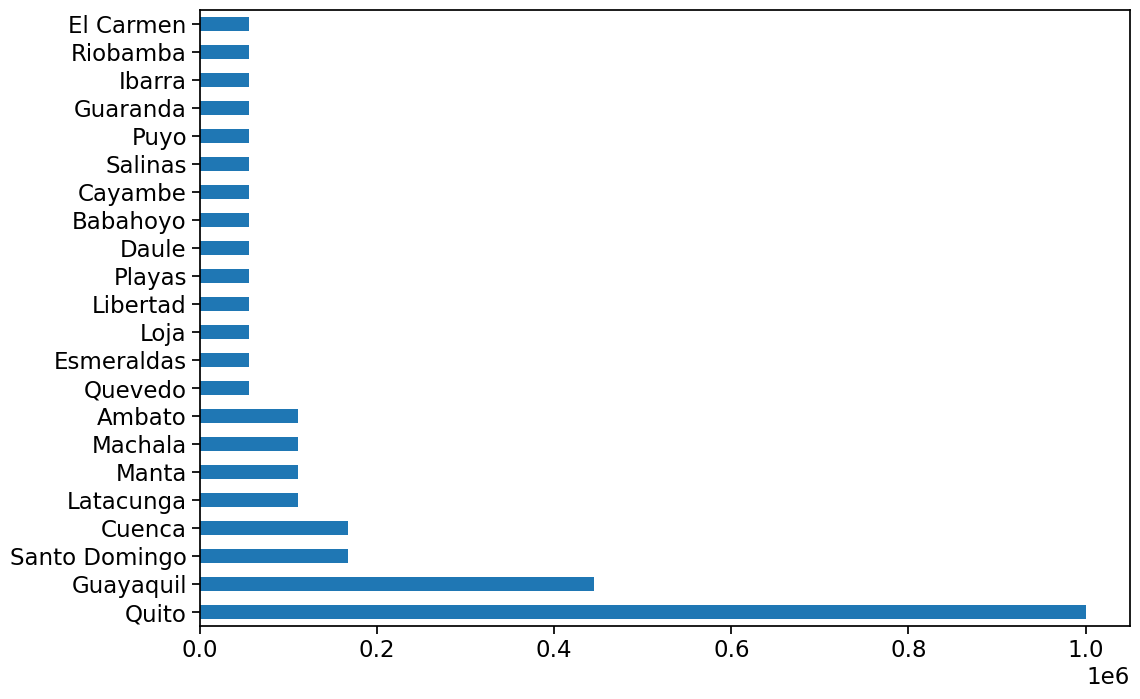

In [296]:
plt.figure(figsize=(12,8))
df_non_num.city.value_counts().plot(kind='barh')
plt.show()

* Stores in city **Quito** have highest frequency in the dataset followed by **Guayaquil**.

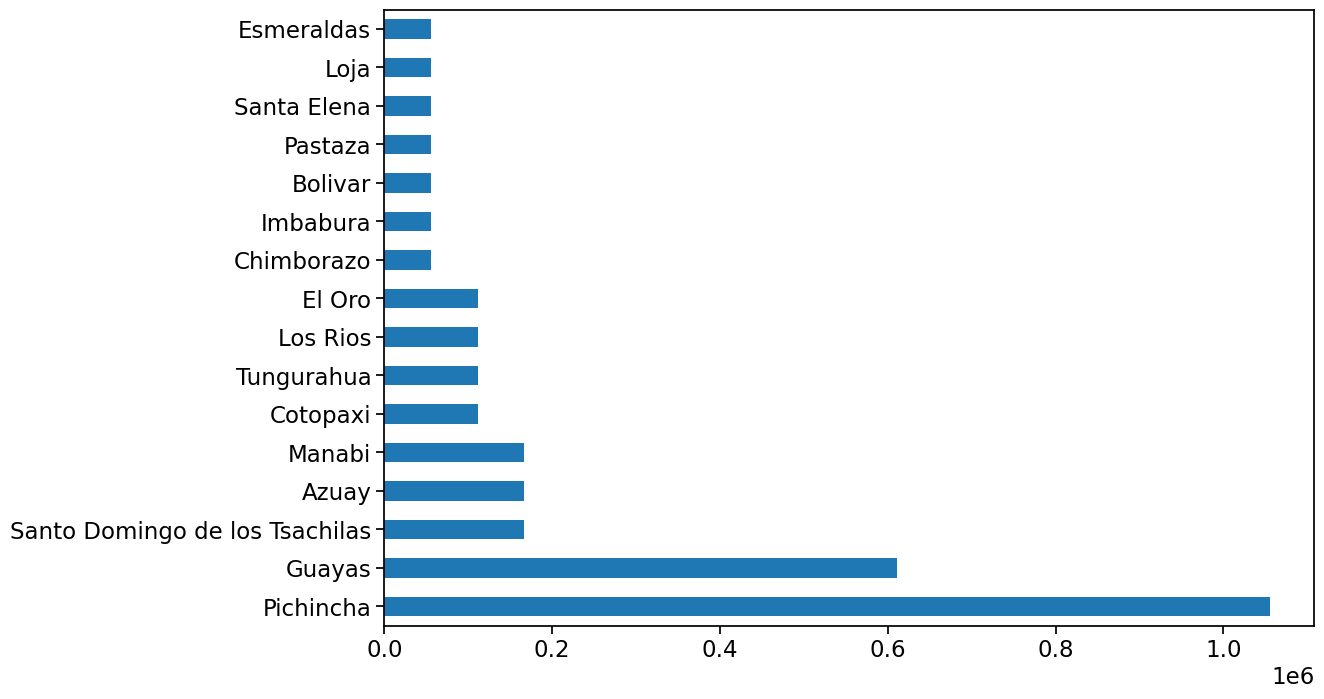

In [297]:
plt.figure(figsize=(12,8))
df_non_num.state.value_counts().plot(kind='barh')
plt.show()

* As expected, frequency of state are also similar to city.

Let's see **type** variable.

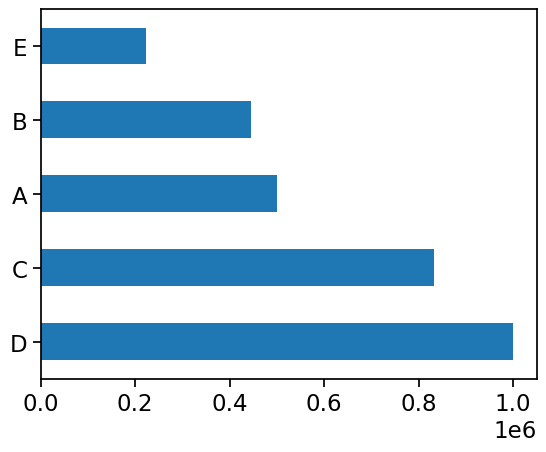

In [298]:
# plt.figure(figsize=(12,8))
df_non_num.type.value_counts().plot(kind='barh')
plt.show()

Let's see **cluster** variable.

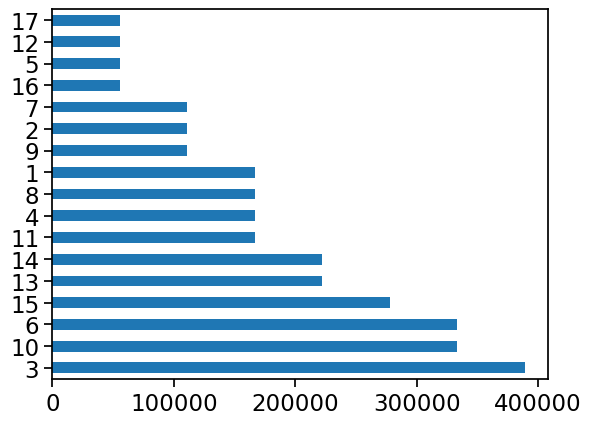

In [299]:
df_num.cluster.value_counts().plot(kind='barh')
plt.show()

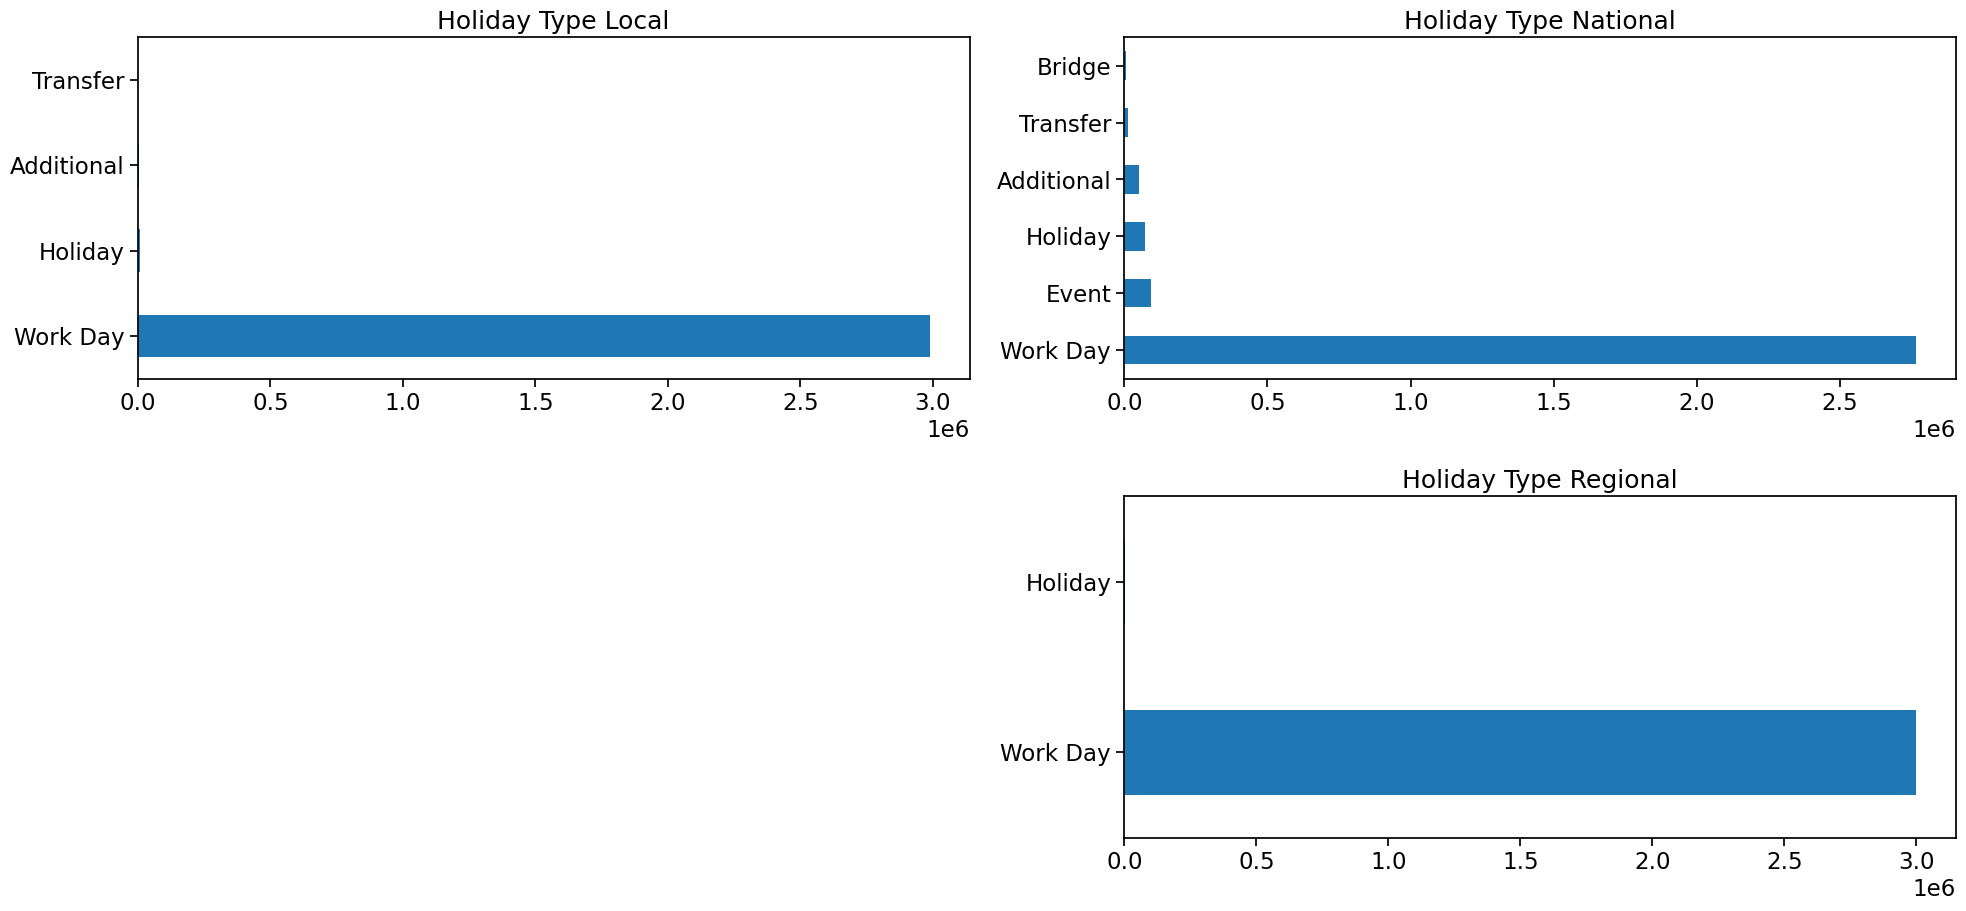

In [300]:
fig = plt.figure(layout="constrained", figsize=(20,18))
ax1 = plt.subplot2grid((4,2), (0,0))
ax2 = plt.subplot2grid((4,2), (0,1))
ax3 = plt.subplot2grid((4,2), (1,1))

df_non_num.type_local.value_counts().plot(kind='barh', ax=ax1, title="Holiday Type Local")
df_non_num.type_national.value_counts().plot(kind='barh', ax=ax2, title="Holiday Type National")
df_non_num.type_reg.value_counts().plot(kind='barh', ax=ax3, title="Holiday Type Regional")

plt.tight_layout()
plt.show()

Let's see the distributions of numerical variables.

* **sales:**
* **store_nbr:**
* **onpromotion:**
* **transactions:**
* **dcoilwtico:**

<Figure size 800x800 with 0 Axes>

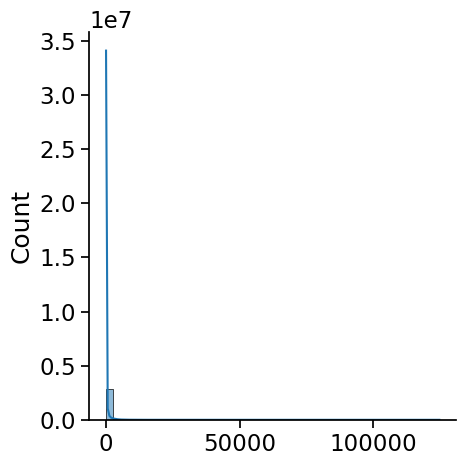

In [302]:
plt.figure(figsize=(8,8))
sns.displot((df_num.sales.values), bins=50, kde=True)
plt.show()

* A large proportion of the **sales** is 0, let's plot the log distribution.

<Figure size 800x800 with 0 Axes>

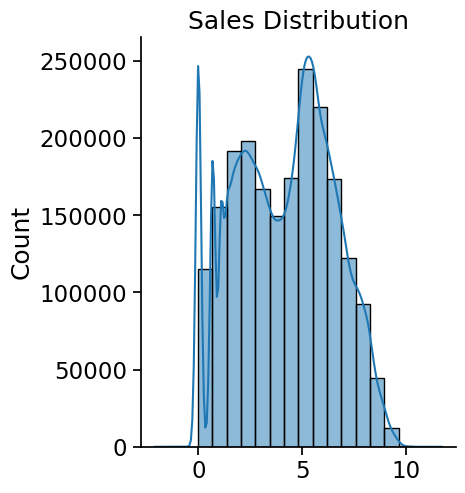

In [303]:
plt.figure(figsize=(8,8))
sns.displot(np.log(df_num.sales.values), bins=20, kde=True)
plt.title("Sales Distribution")
plt.show()

* **Stores:**

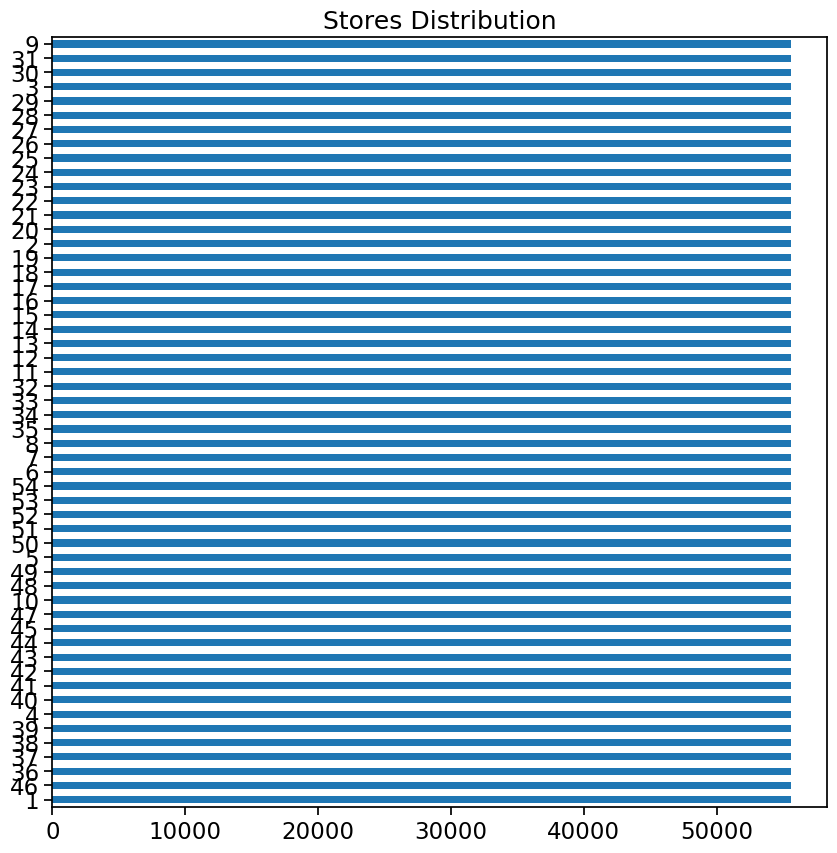

In [304]:
plt.figure(figsize=(10,10))
df_num.store_nbr.value_counts().plot(kind='barh')
plt.title("Stores Distribution")
plt.show()

* All stores have same frequency in data.


* **onpromotion:**

<Figure size 1000x800 with 0 Axes>

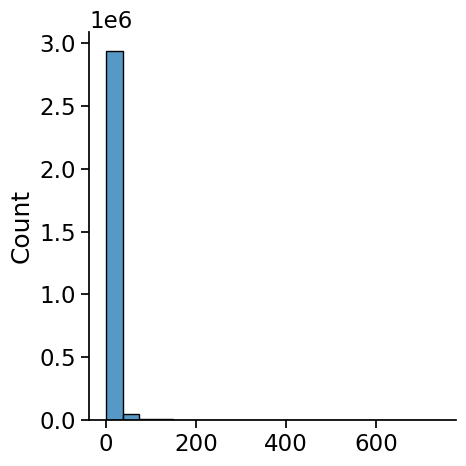

In [305]:
plt.figure(figsize=(10,8))
sns.displot((df_num.onpromotion.values), bins=20)
plt.show()

Most of the values are 0n let's plot log

<Figure size 1000x800 with 0 Axes>

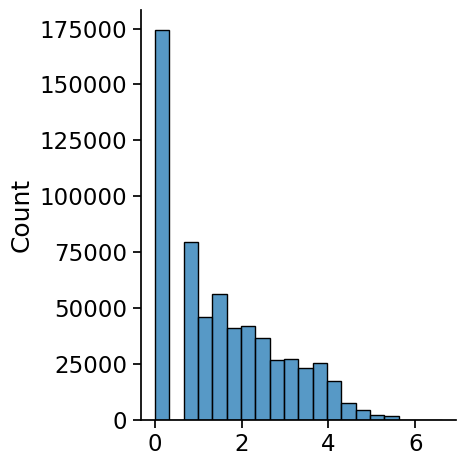

In [306]:
plt.figure(figsize=(10,8))
sns.displot(np.log(df_num.onpromotion.values), bins=20)
plt.show()

* **dcoilwtico:**

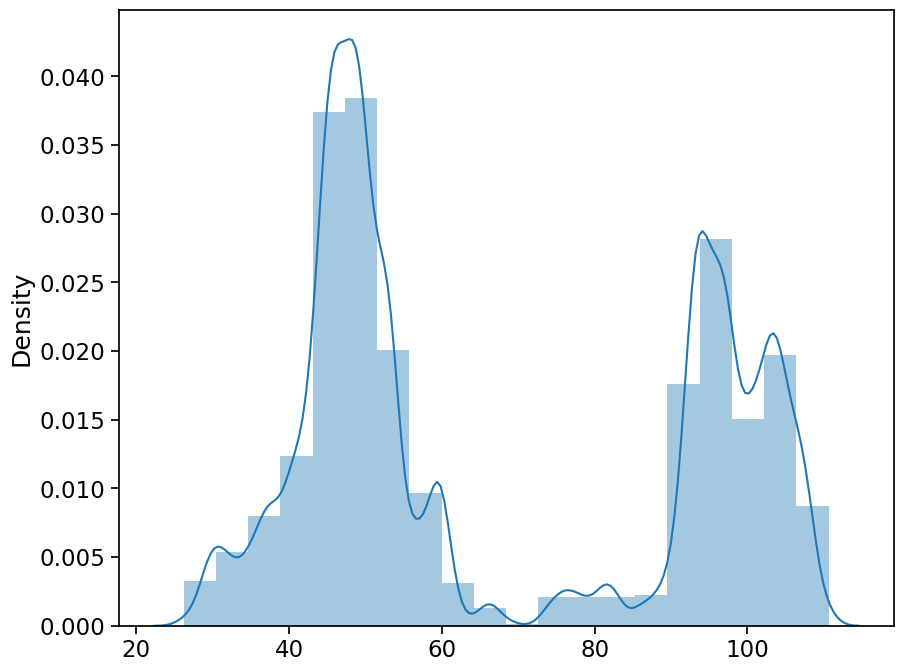

In [307]:
plt.figure(figsize=(10,8))
sns.distplot((df_num.dcoilwtico.values), bins=20)
plt.show()

#### 2.3.2. Multivariate Analysis

* How **sales** look for different product **family**?

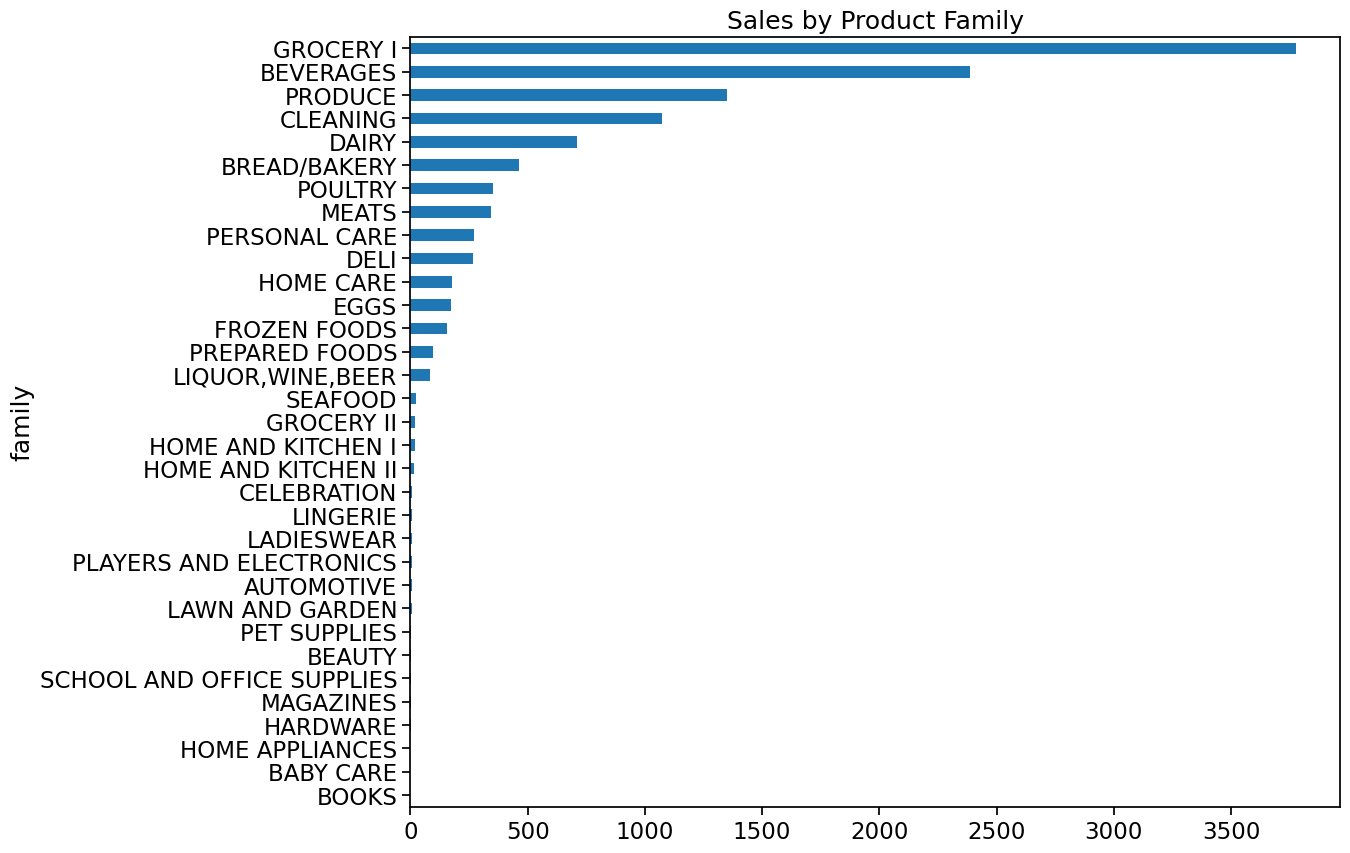

In [308]:
plt.figure(figsize=(12,10))
train_merged.groupby('family')['sales'].mean().sort_values().plot(kind='barh', title="Sales by Product Family")
plt.show()

* **GROCERY I** is highest selling product family followed by **BEVERAGES**.

* Let's see how **sales** look for different **city** and **state**.

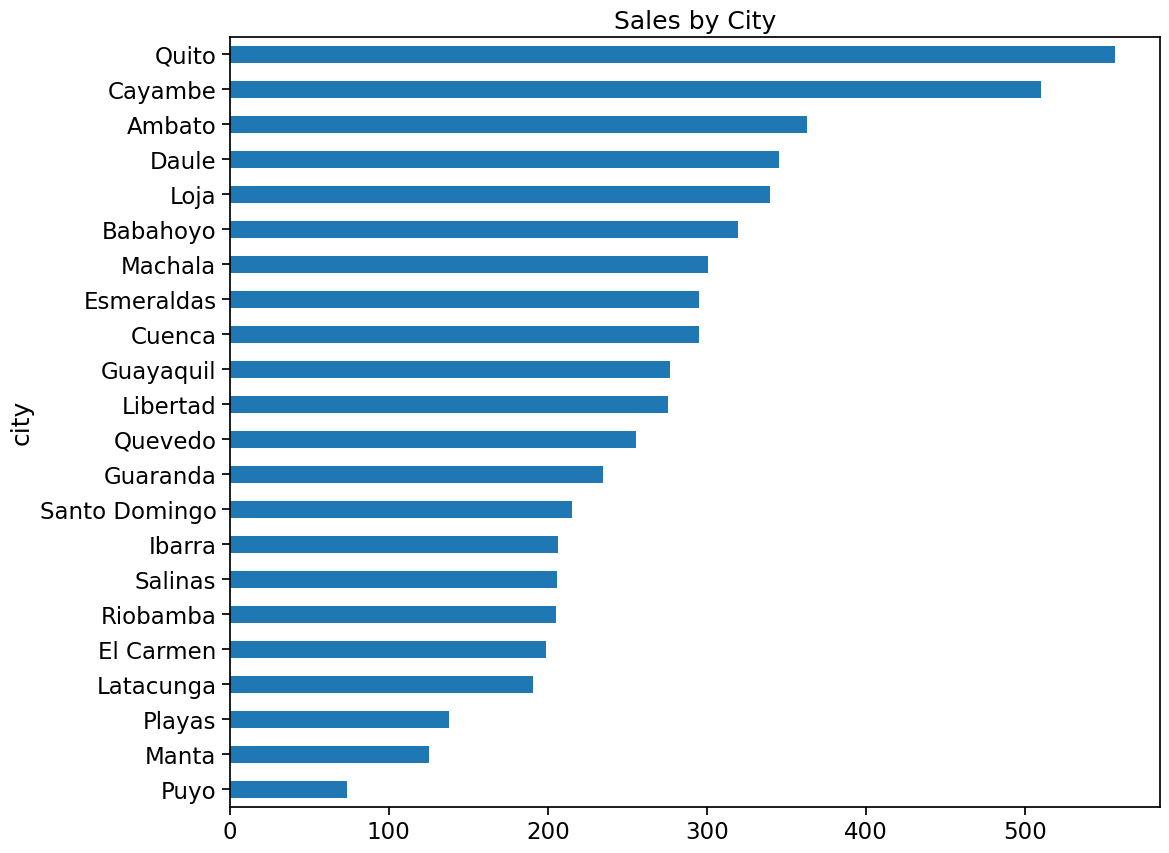

In [309]:
plt.figure(figsize=(12,10))
train_merged.groupby('city')['sales'].mean().sort_values().plot(kind='barh', title="Sales by City")
plt.show()

* **Quito** and **Cayas** have highest sales.

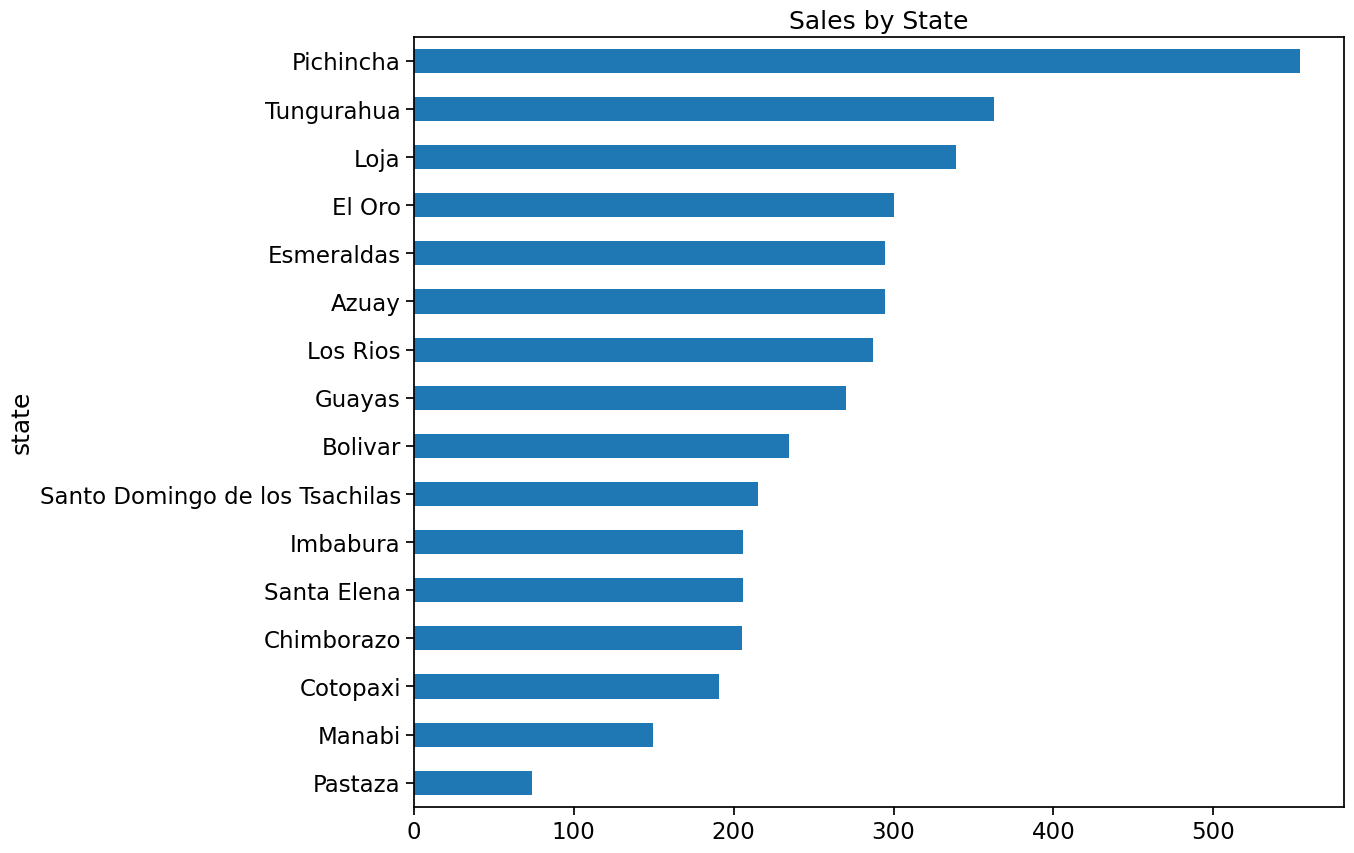

In [310]:
plt.figure(figsize=(12,10))
train_merged.groupby('state')['sales'].mean().sort_values().plot(kind='barh', title="Sales by State")
plt.show()

* **Pichincha** has highest sales, followed bu **Tungurahua** and **Loja**.

* Let's see how **sales** look for different **product_type**.

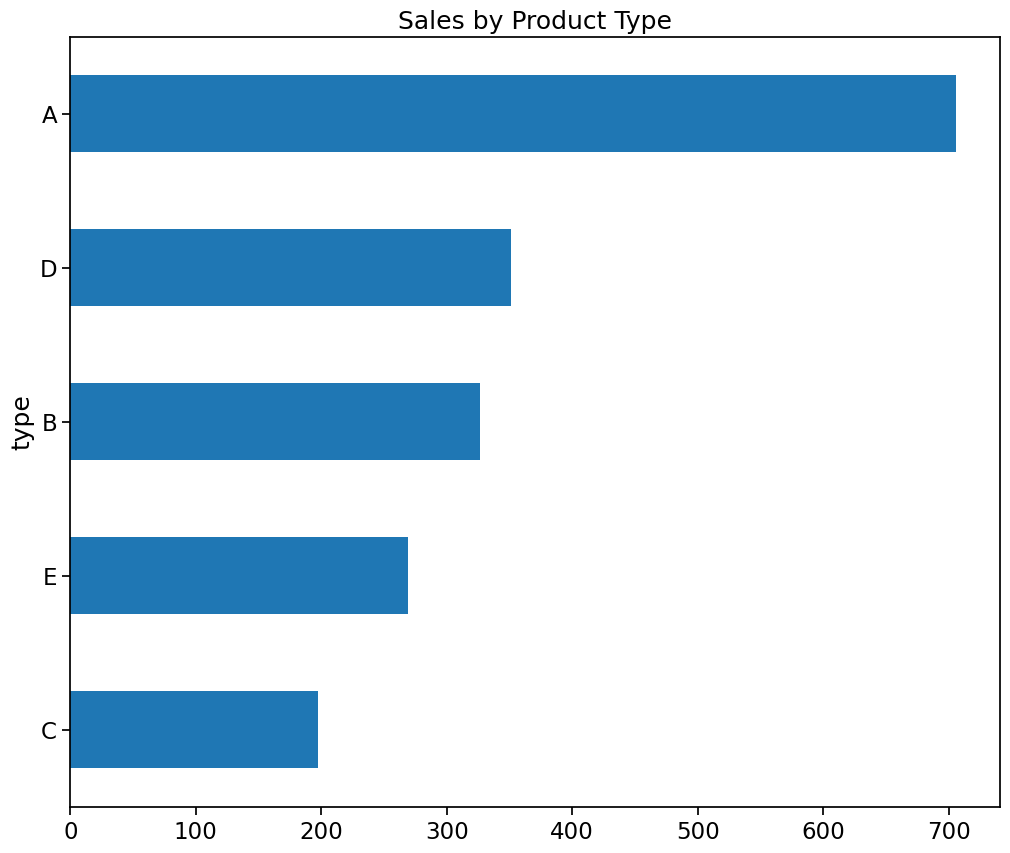

In [312]:
plt.figure(figsize=(12,10))
train_merged.groupby('type')['sales'].mean().sort_values().plot(kind='barh', title="Sales by Product Type")
plt.show()

* Produc type **A** has highest sales.

* Let's see how **sales** look for different **cluster**.

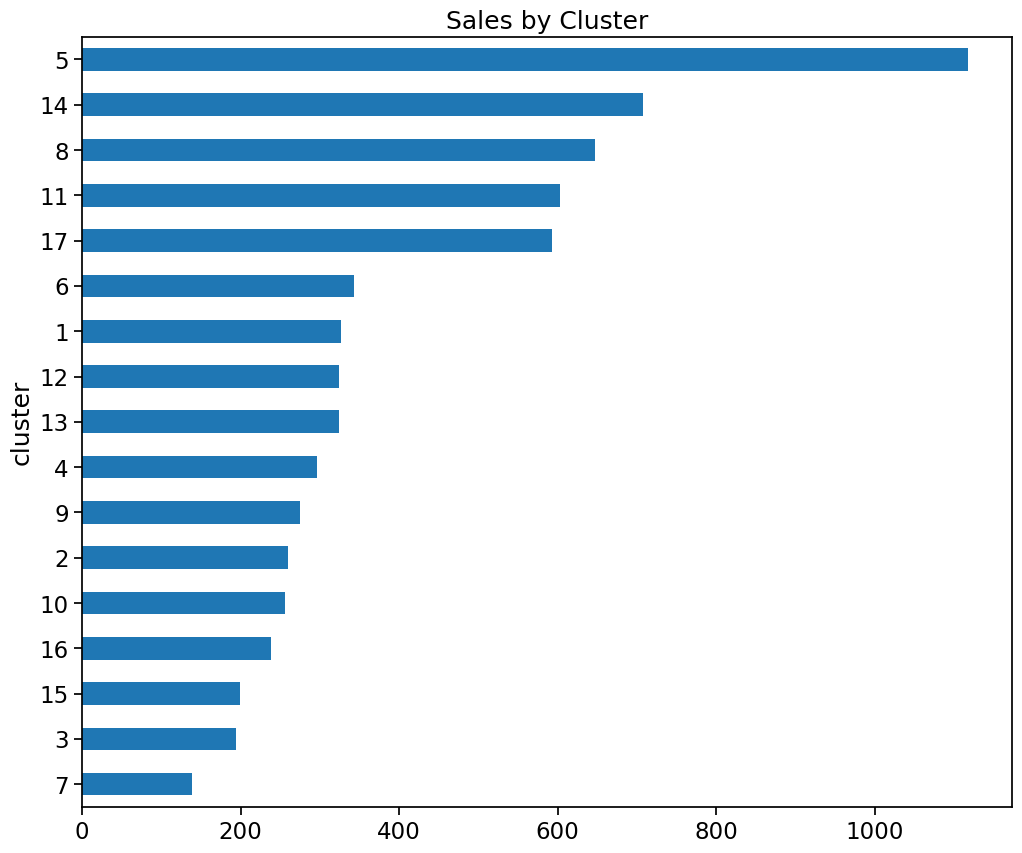

In [313]:
plt.figure(figsize=(12,10))
train_merged.groupby('cluster')['sales'].mean().sort_values().plot(kind='barh', title="Sales by Cluster")
plt.show()

* Let's see how **sales** look over time.

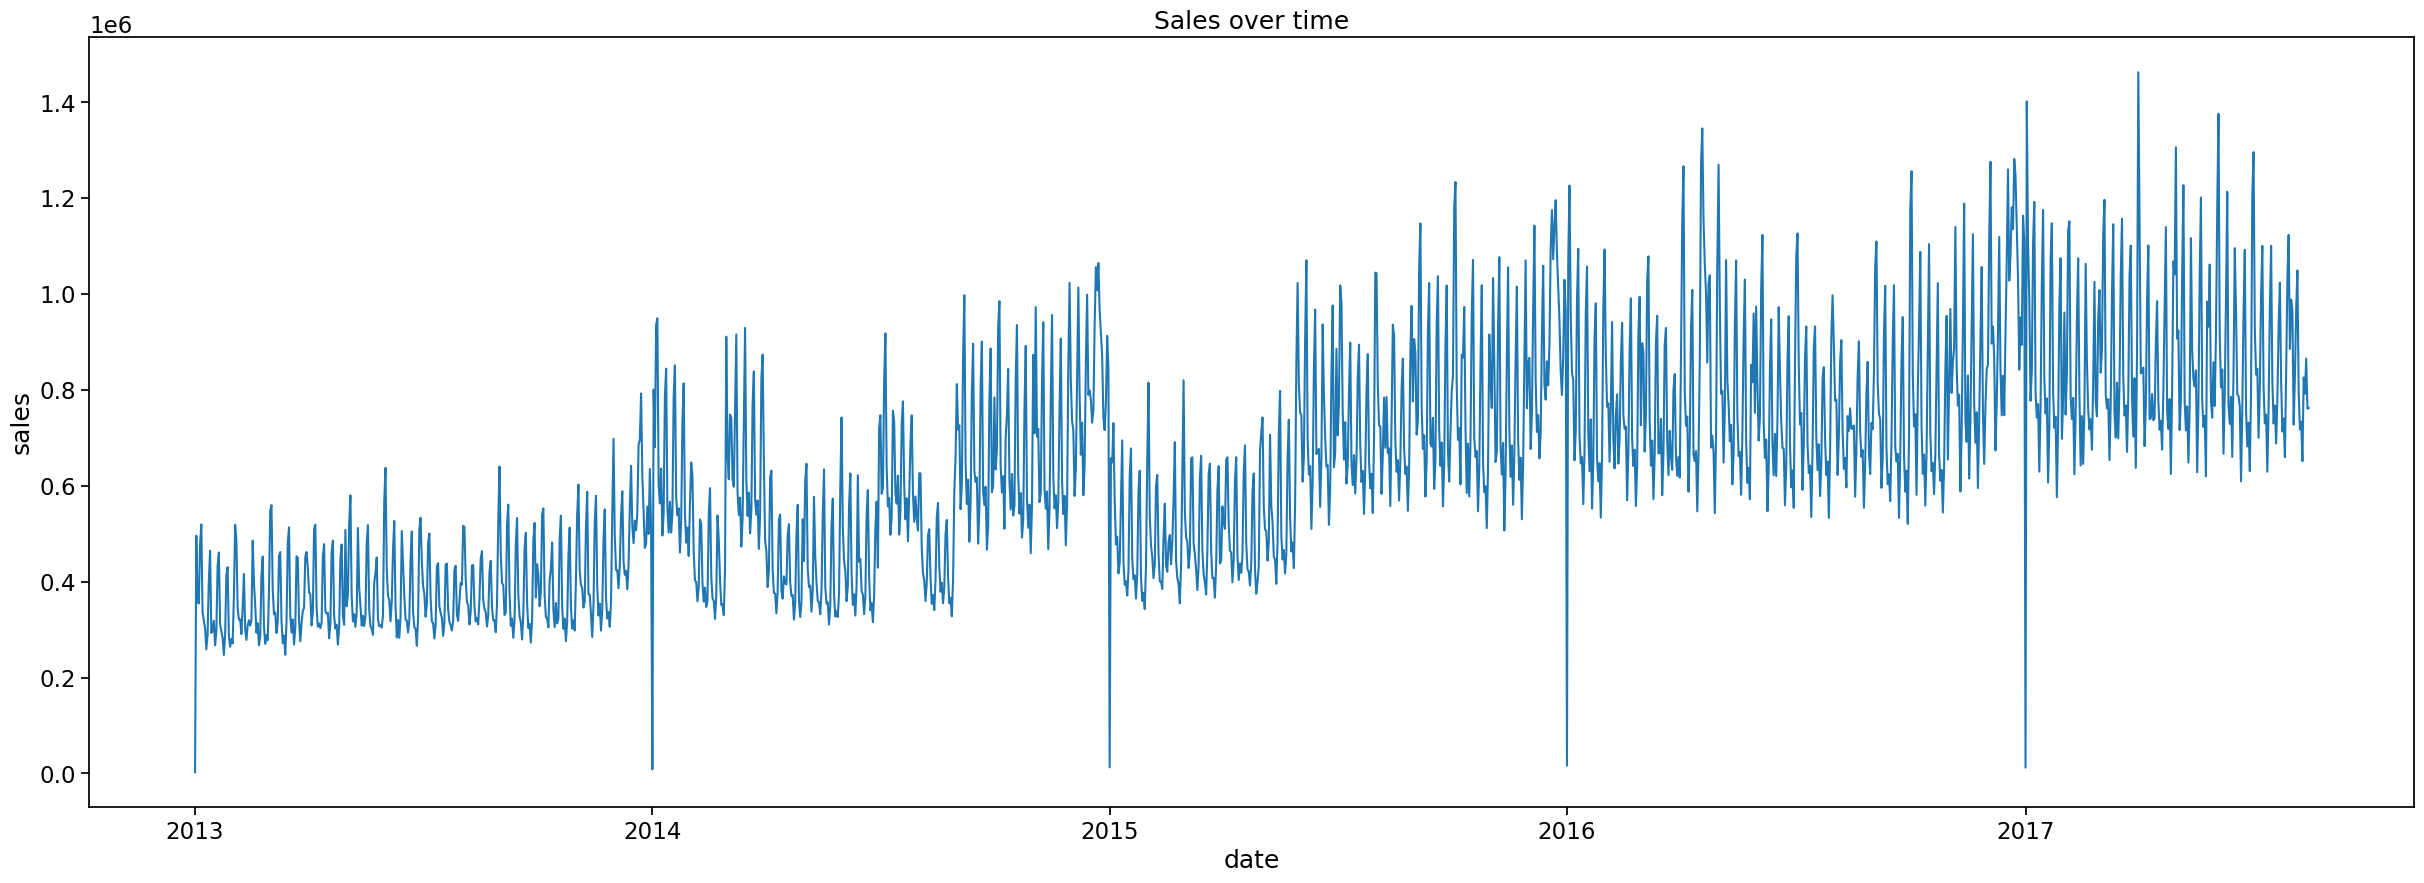

In [314]:
# Sum of units sold daily
df_daily_sales = train_merged.groupby(['date'])['sales'].sum()

plt.figure(figsize=(30,10))
sns.lineplot(x=df_daily_sales.index, y=df_daily_sales)
plt.title("Sales over time")
plt.show()

* We can see a clear jump in sales near the end of every year, this shows seasonality in the data.
* Sales are increasing ove time

* Let's see the average **sales** by **family** over time.

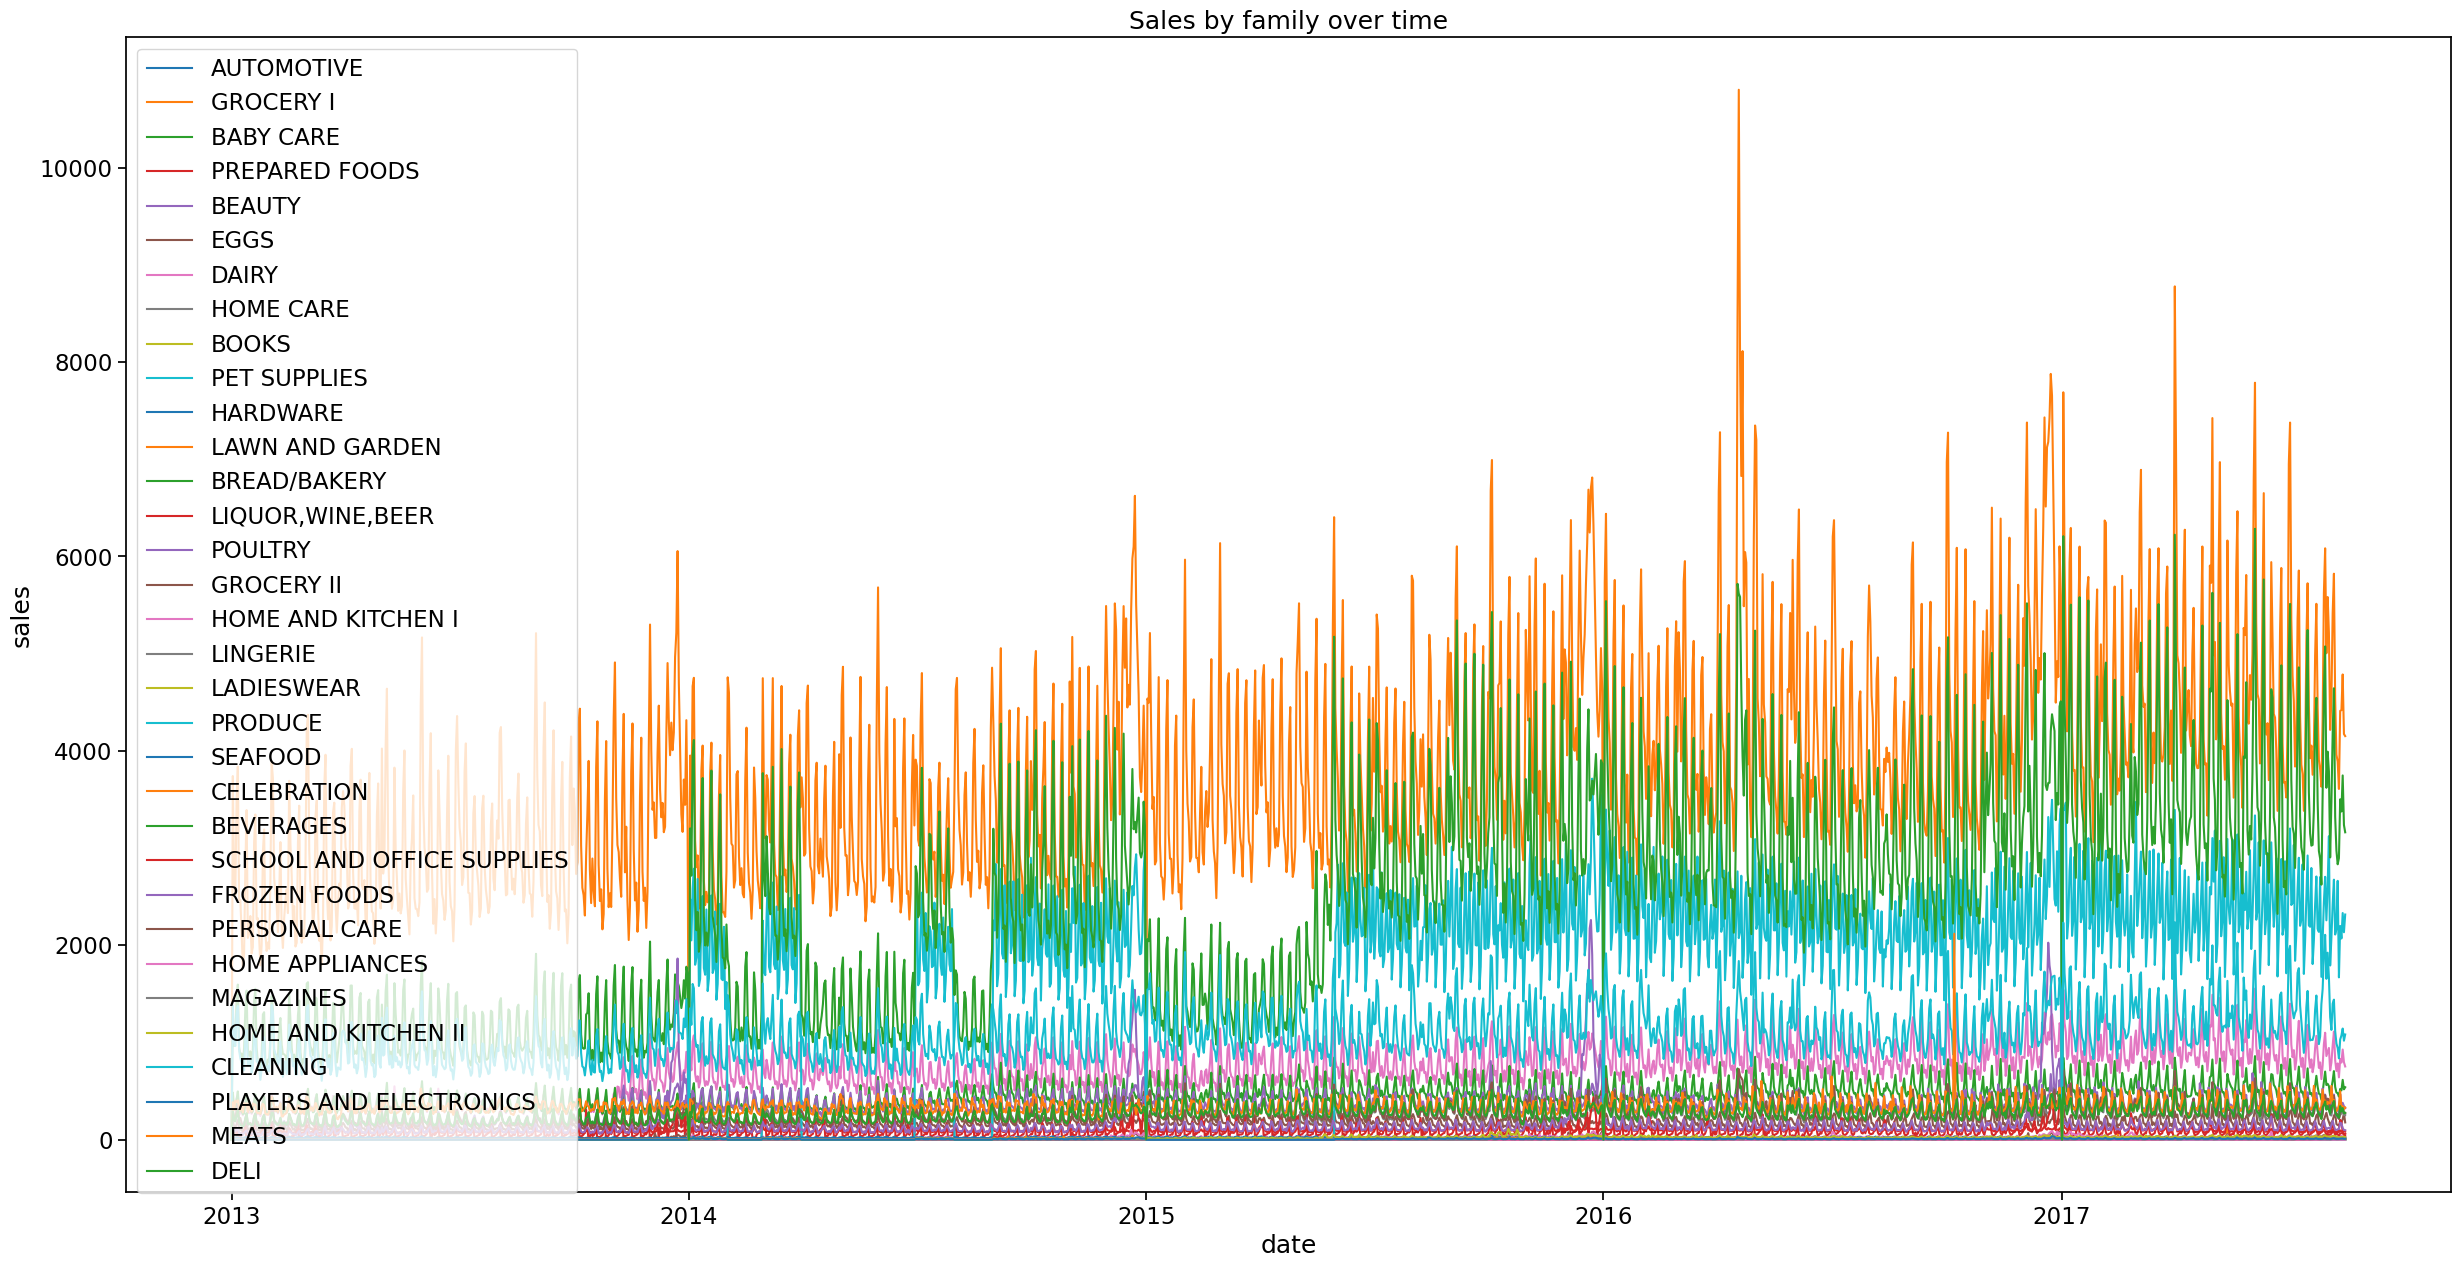

In [315]:
plt.figure(figsize=(30,15))
for f in set(train_merged.family.values):
    df_sales_by_f = train_merged[train_merged.family == f].groupby(['date'])['sales'].mean()
    sns.lineplot(x=df_sales_by_f.index, y=df_sales_by_f, label=f)

plt.legend(loc='upper left')
plt.title("Sales by family over time")
plt.show()


* We can clearly see that there are few product families which have very high sales compared to a large number of product families which have very low sales.

* Let's see the average **sales** by **type**

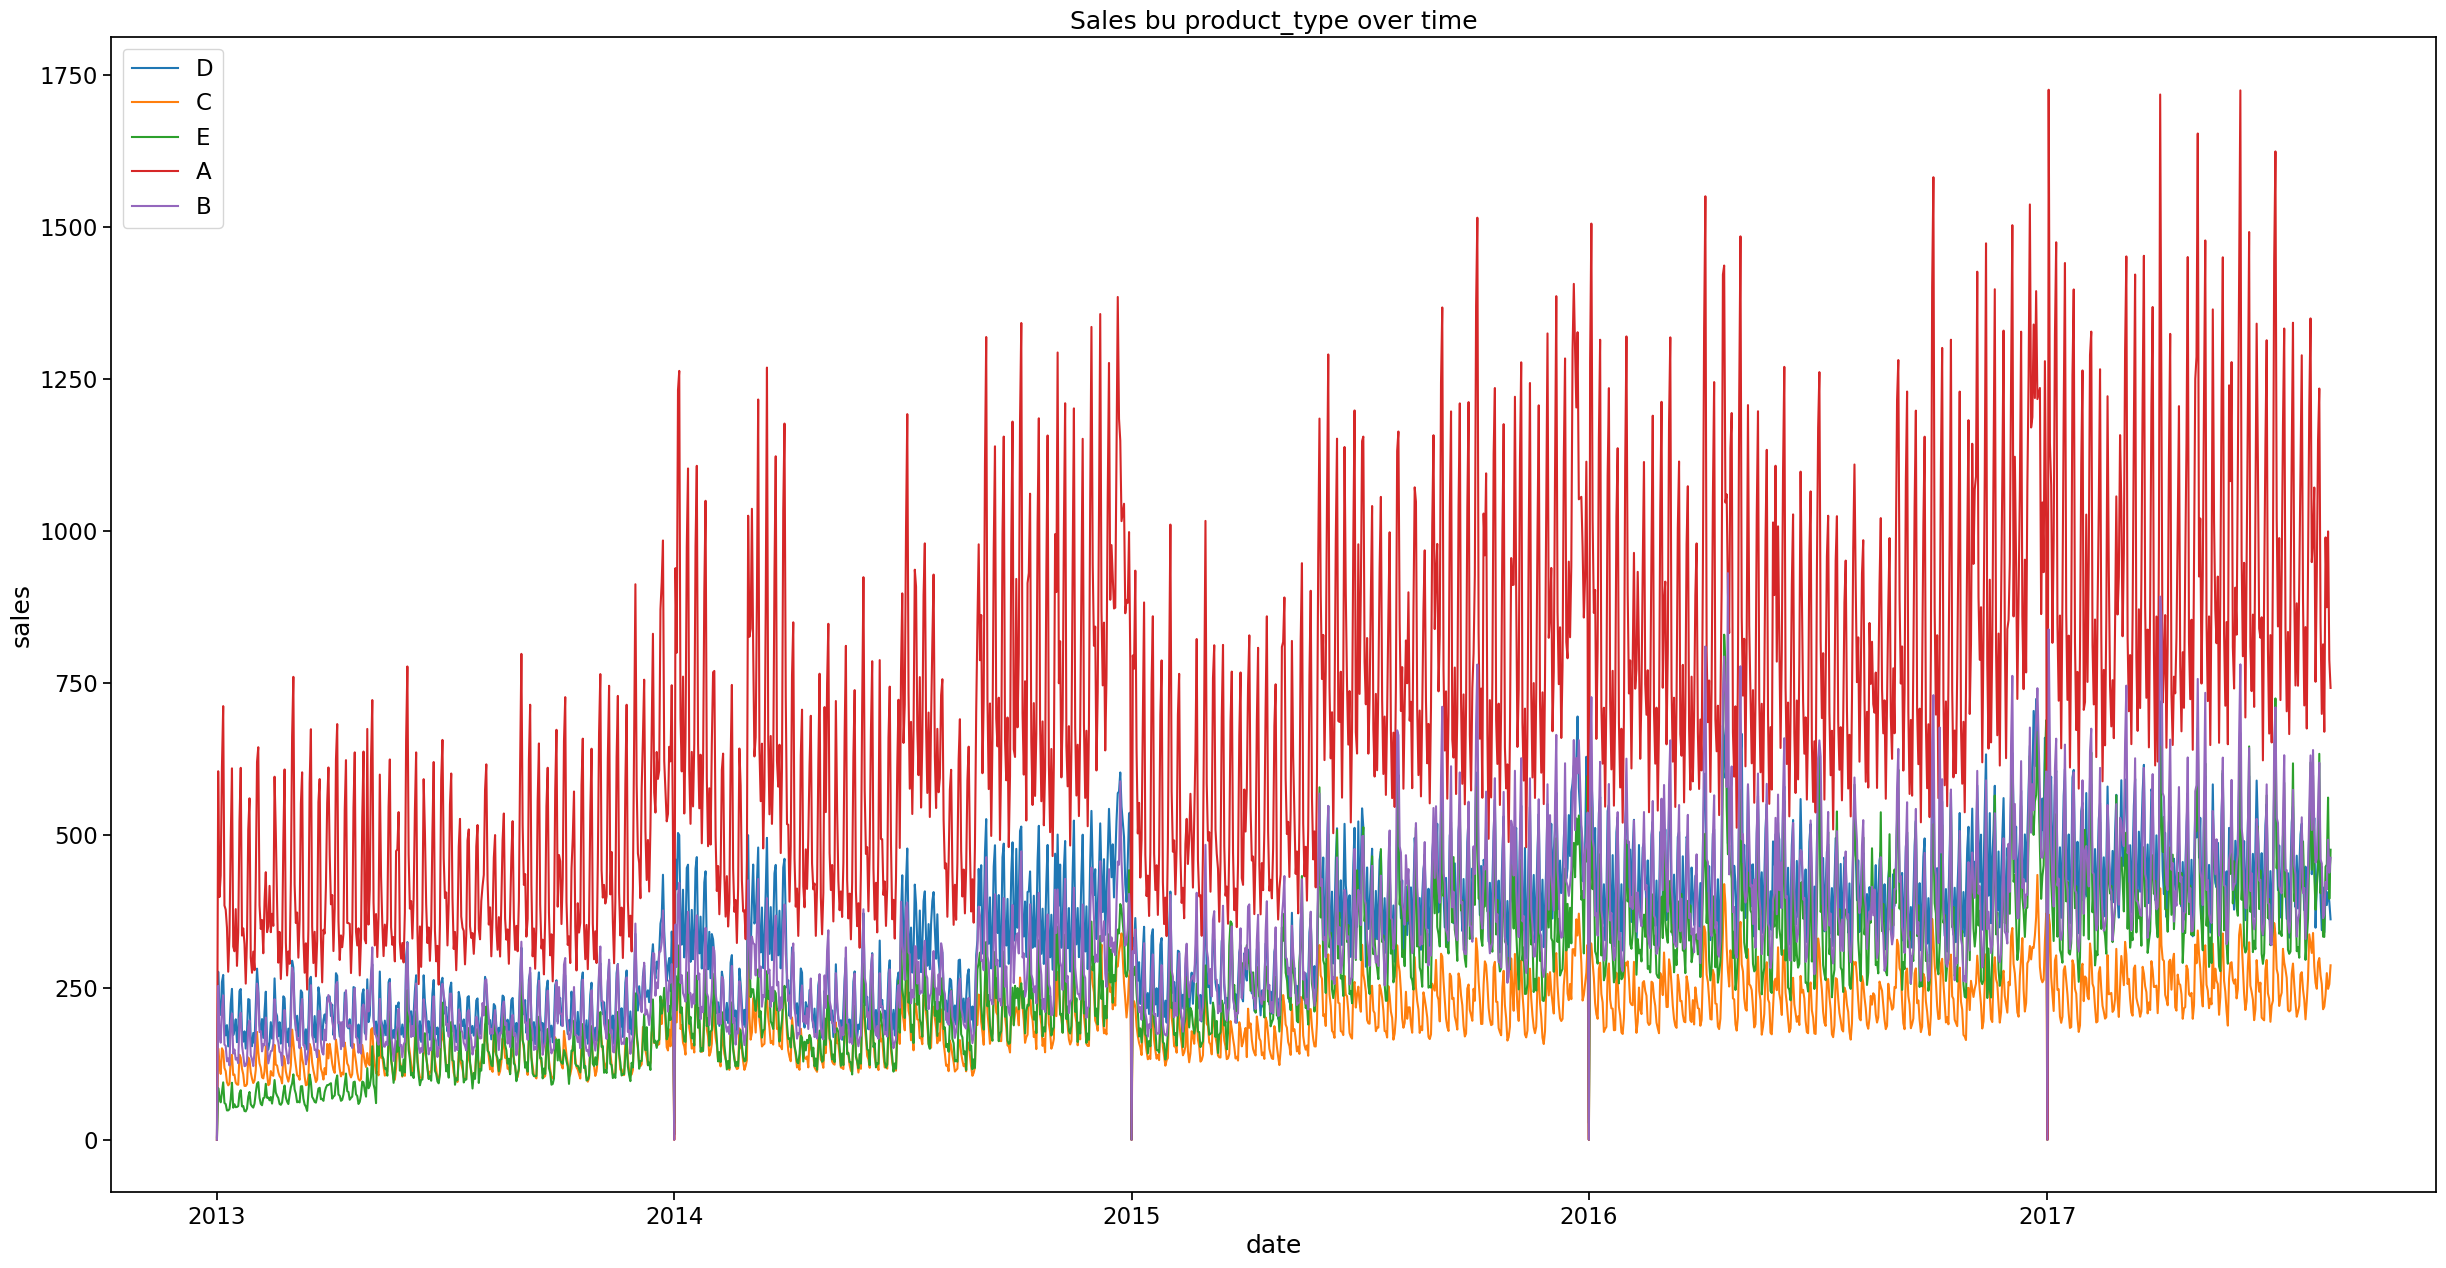

In [317]:
plt.figure(figsize=(30,15))
for p in set(train_merged.type.values):
    df_sales_by_p = train_merged[train_merged.type == p].groupby(['date'])['sales'].mean()
    sns.lineplot(x=df_sales_by_p.index, y=df_sales_by_p, label=p)

plt.legend(loc='upper left')
plt.title("Sales bu product_type over time")
plt.show()


* We can see that product type **A** has highest sales over time.

Let's see how the sales affected by the holidays.

In [320]:
train_merged.type_national.value_counts()

Work Day      2767446
Event           94446
Holiday         71280
Additional      49896
Transfer        12474
Bridge           5346
Name: type_national, dtype: int64

In [321]:
# Let's create a column to indicate if there was a holiday on the date
train_merged['is_national_holiday'] = train_merged.type_national.apply(lambda x: 99999 if x in ('Holiday', 'Additional', 'Transfer', 'Event', 'Bridge') else 0)
train_merged.is_national_holiday.fillna(0, inplace=True)
train_merged.is_national_holiday.value_counts()

0        2767446
99999     233442
Name: is_national_holiday, dtype: int64

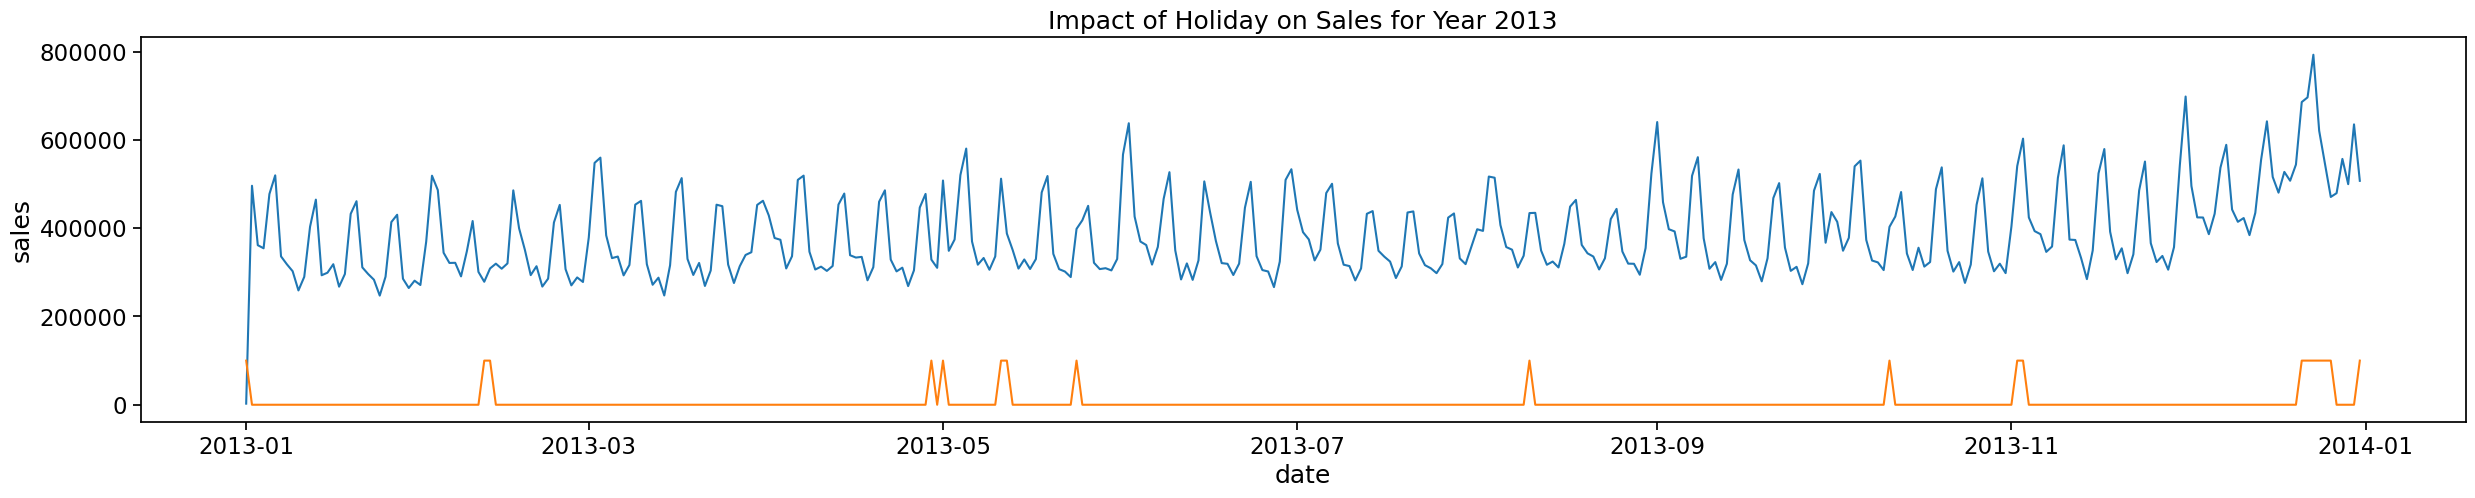

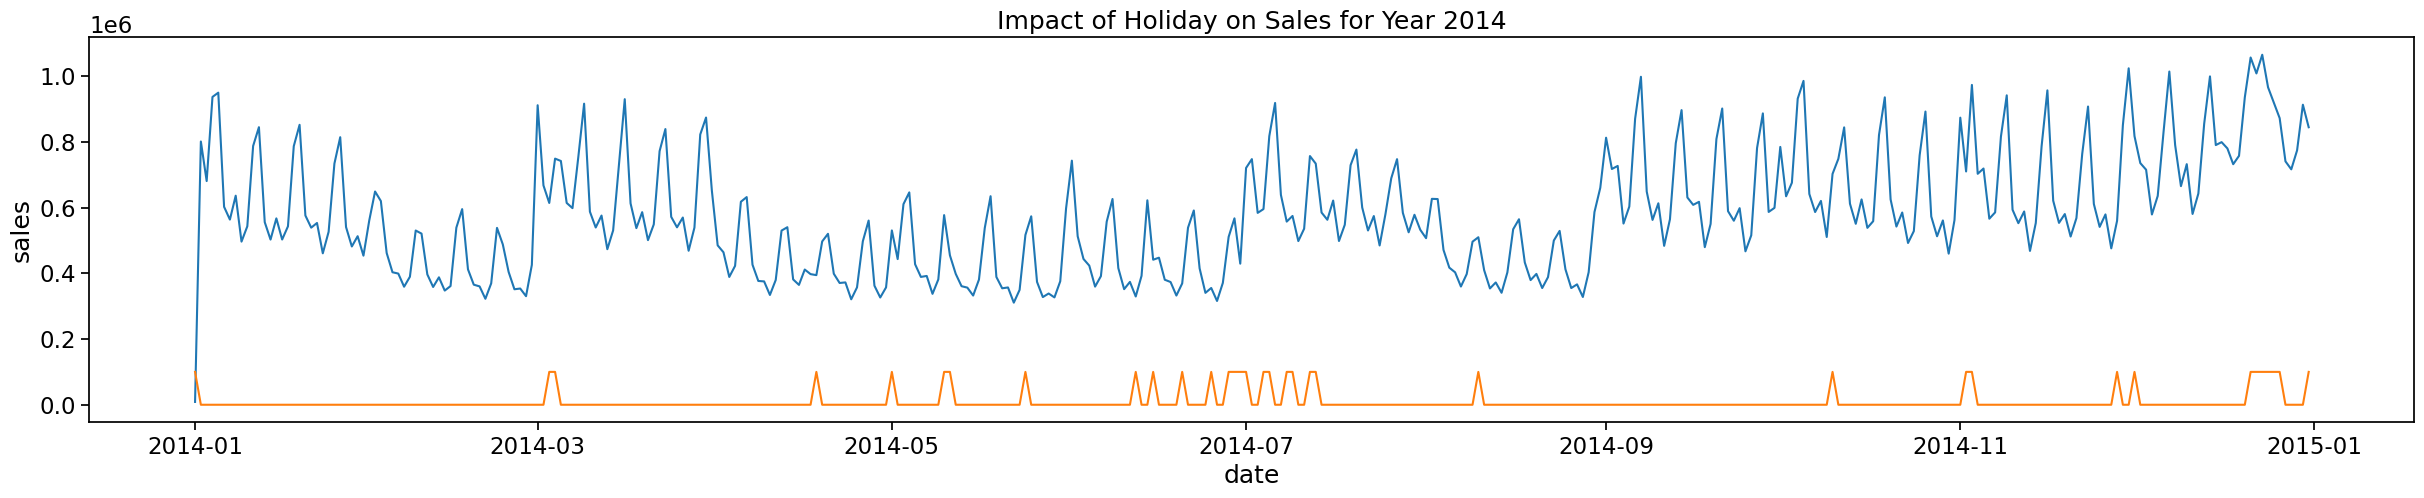

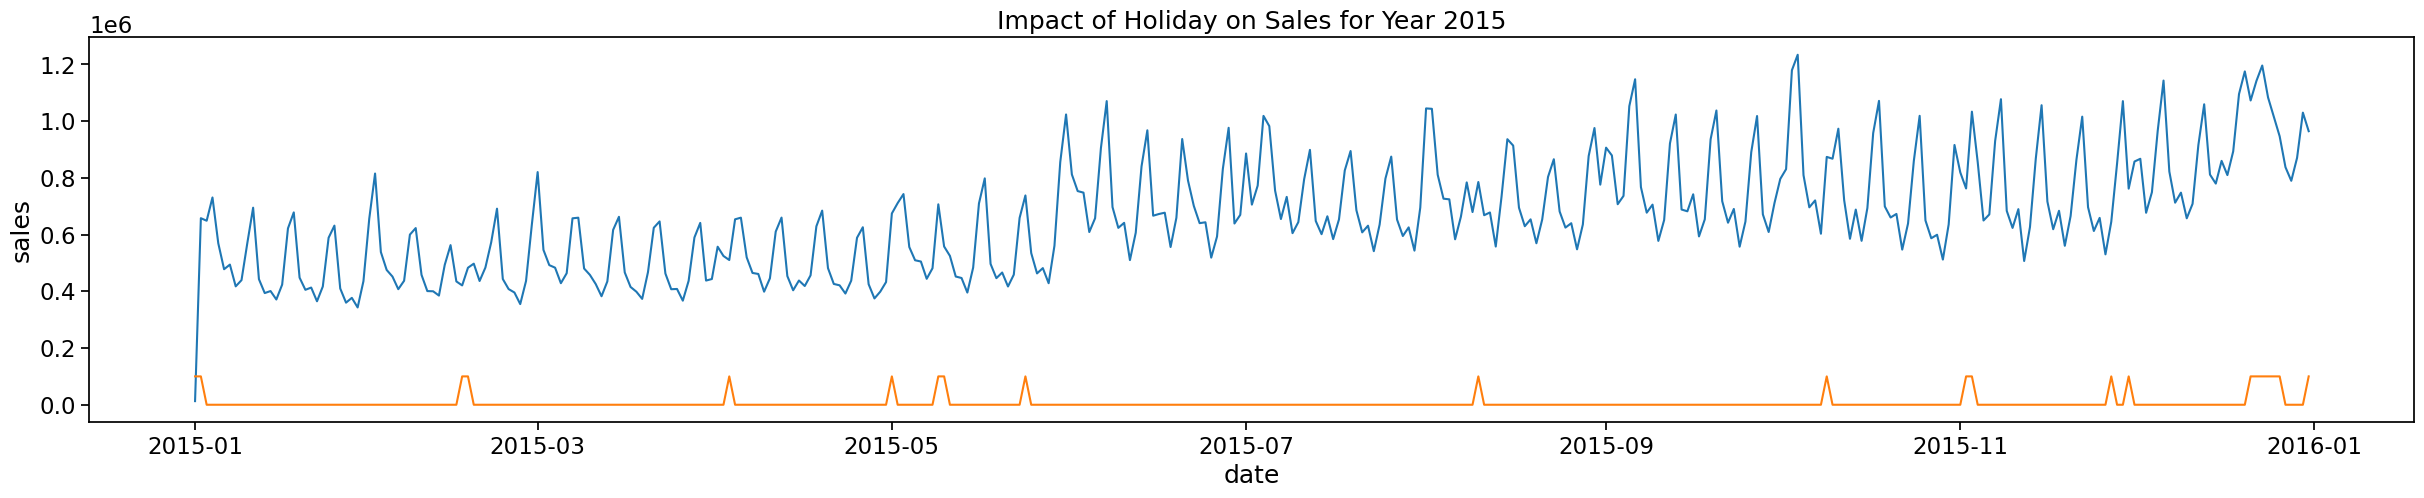

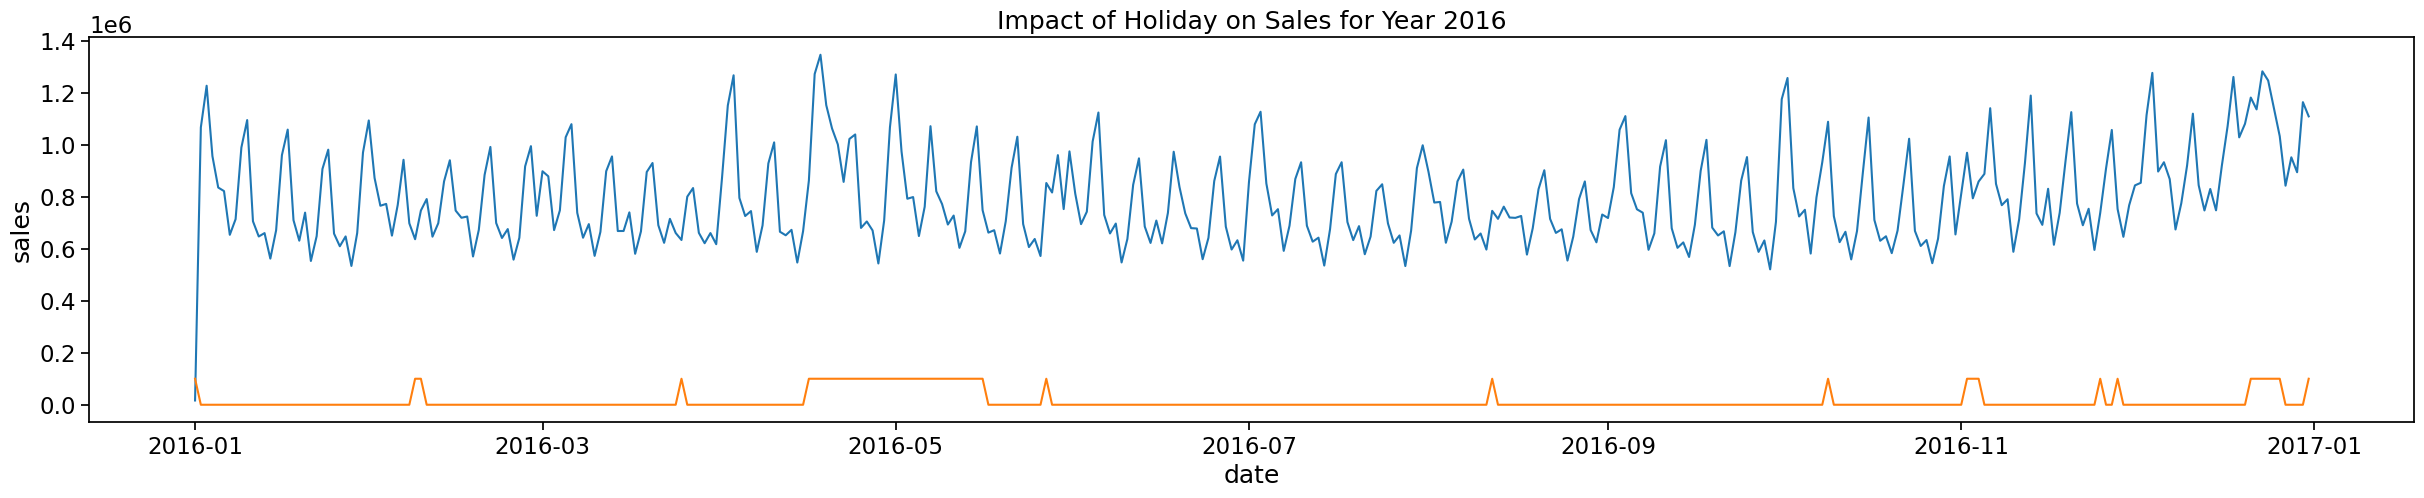

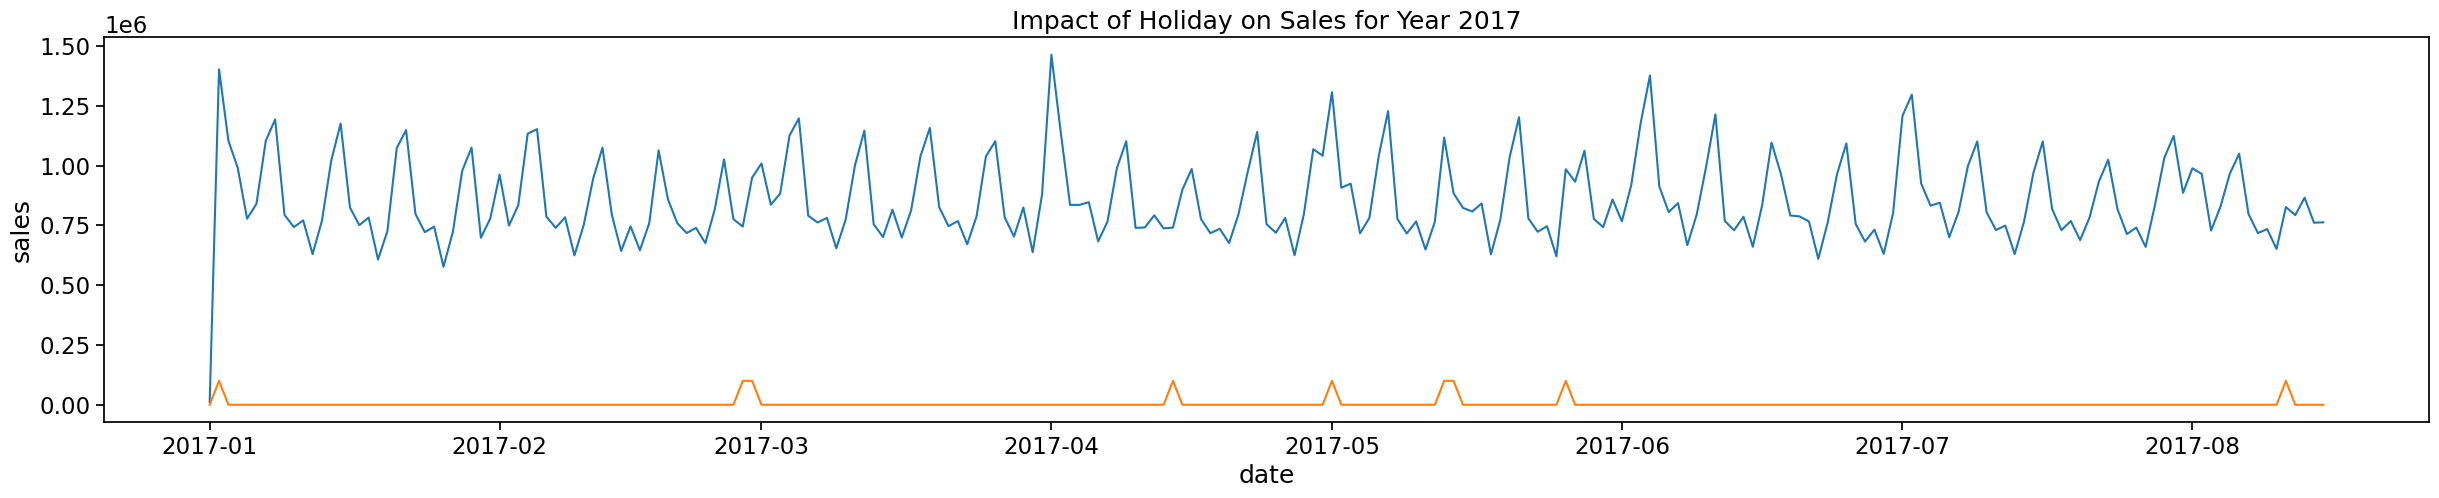

In [324]:
# Ploting impact of holidays on sales over time
for year in train_merged.date.dt.year.unique():
    plt.figure(figsize=(30,5))
    df_daily_sales = train_merged[train_merged.date.dt.year == year].groupby(['date'])['sales'].sum()
    df_holiday = train_merged[train_merged.date.dt.year == year].groupby(['date'])['is_national_holiday'].value_counts()
    sns.lineplot(x=df_daily_sales.index, y=df_daily_sales)
    sns.lineplot(x=df_holiday.index.get_level_values('date'), y=df_holiday.index.get_level_values('is_national_holiday'))
    plt.title(f"Impact of Holiday on Sales for Year {year}")
    plt.show()

* We can see jupmp in sales during the holiday season

Let's see how **onpromotion** affect the **sales**.

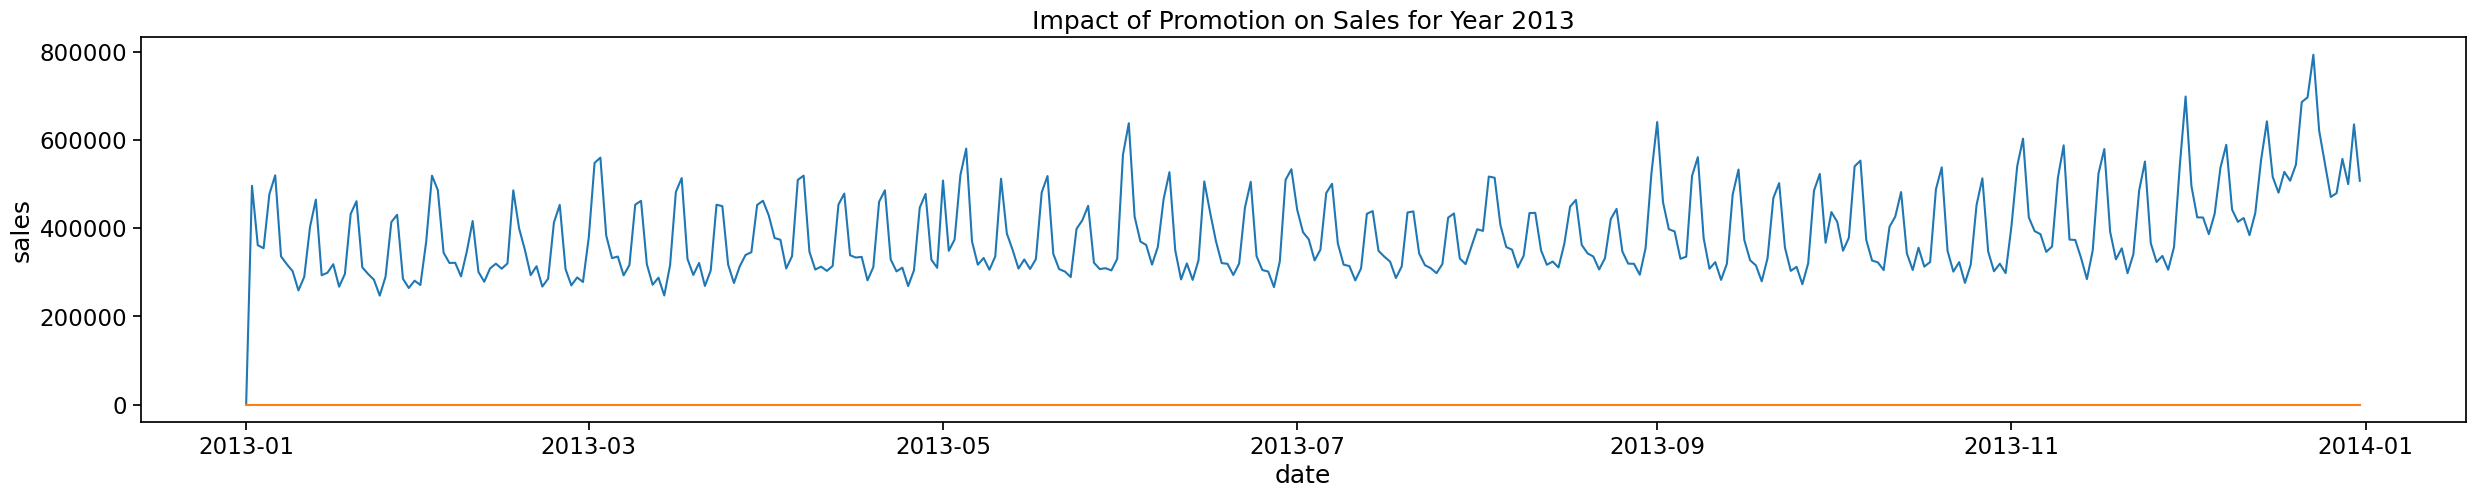

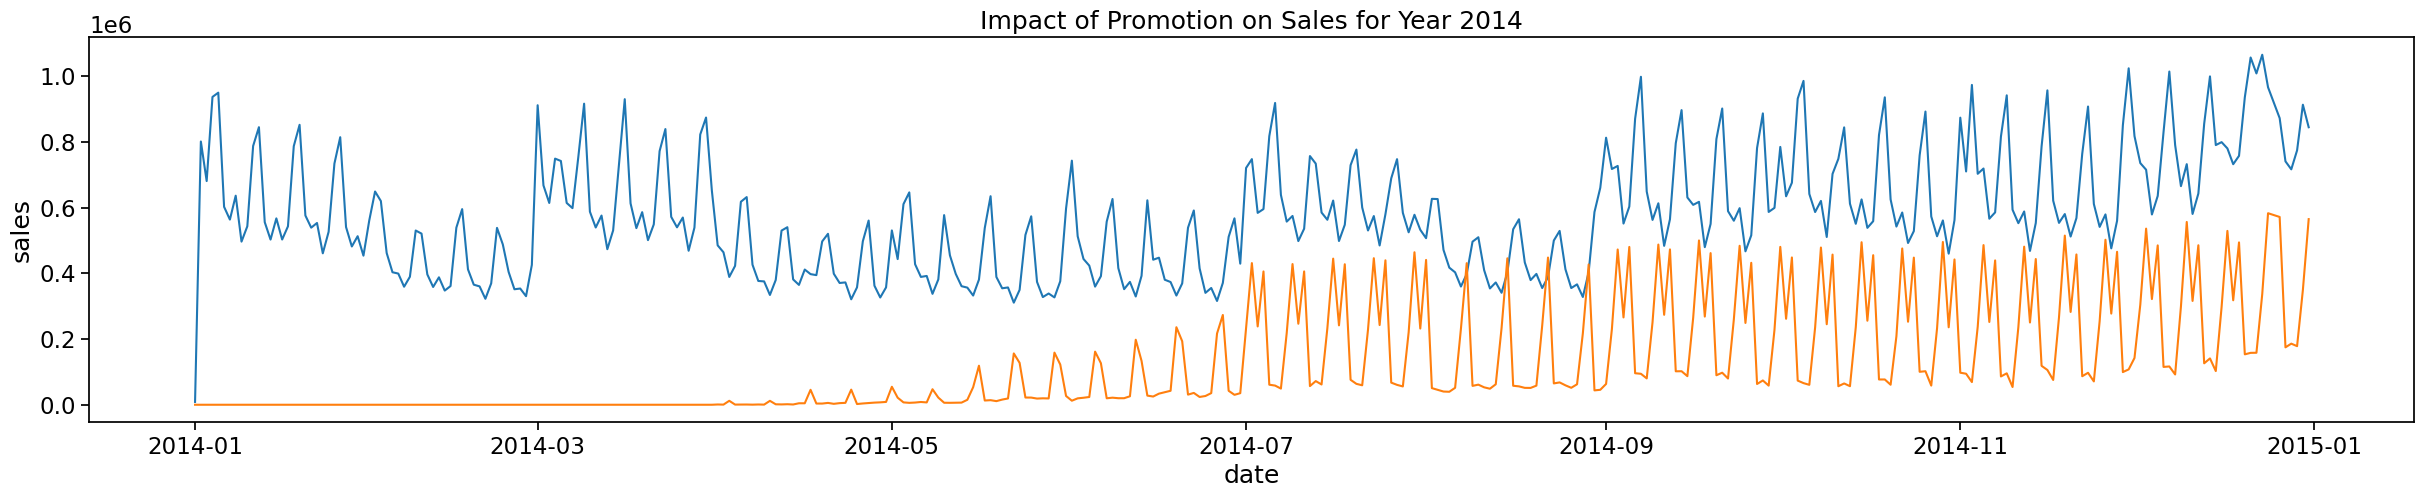

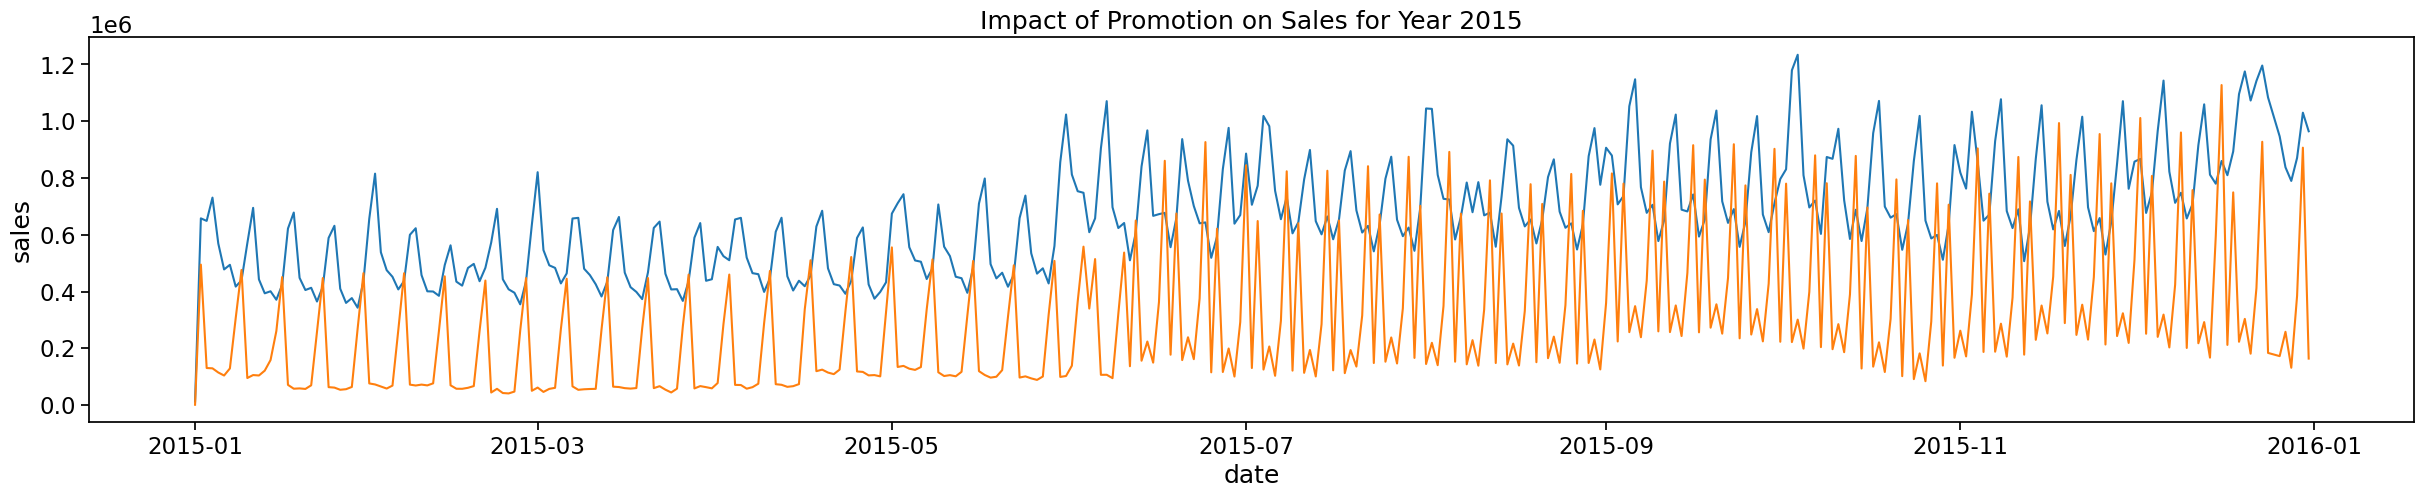

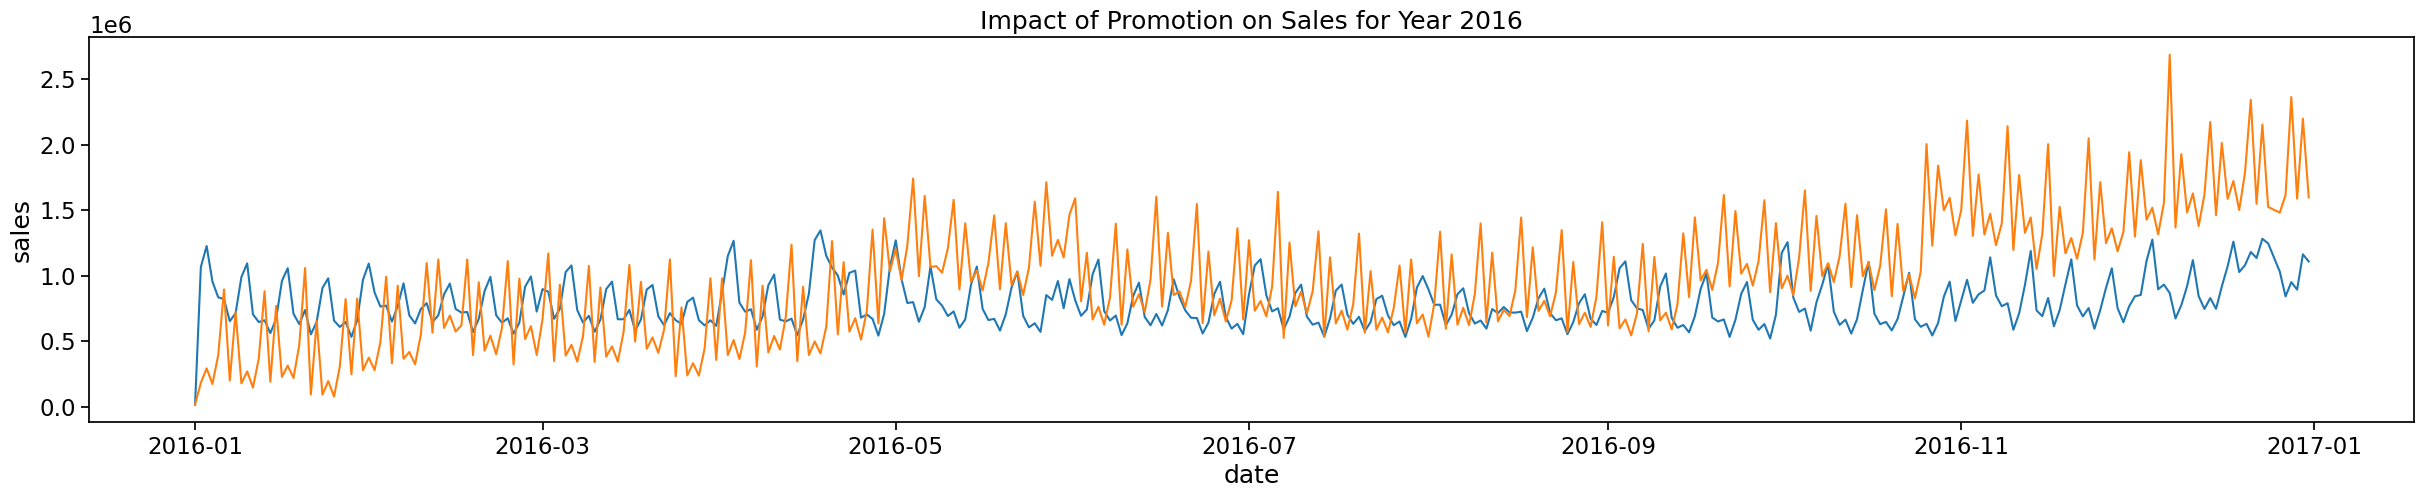

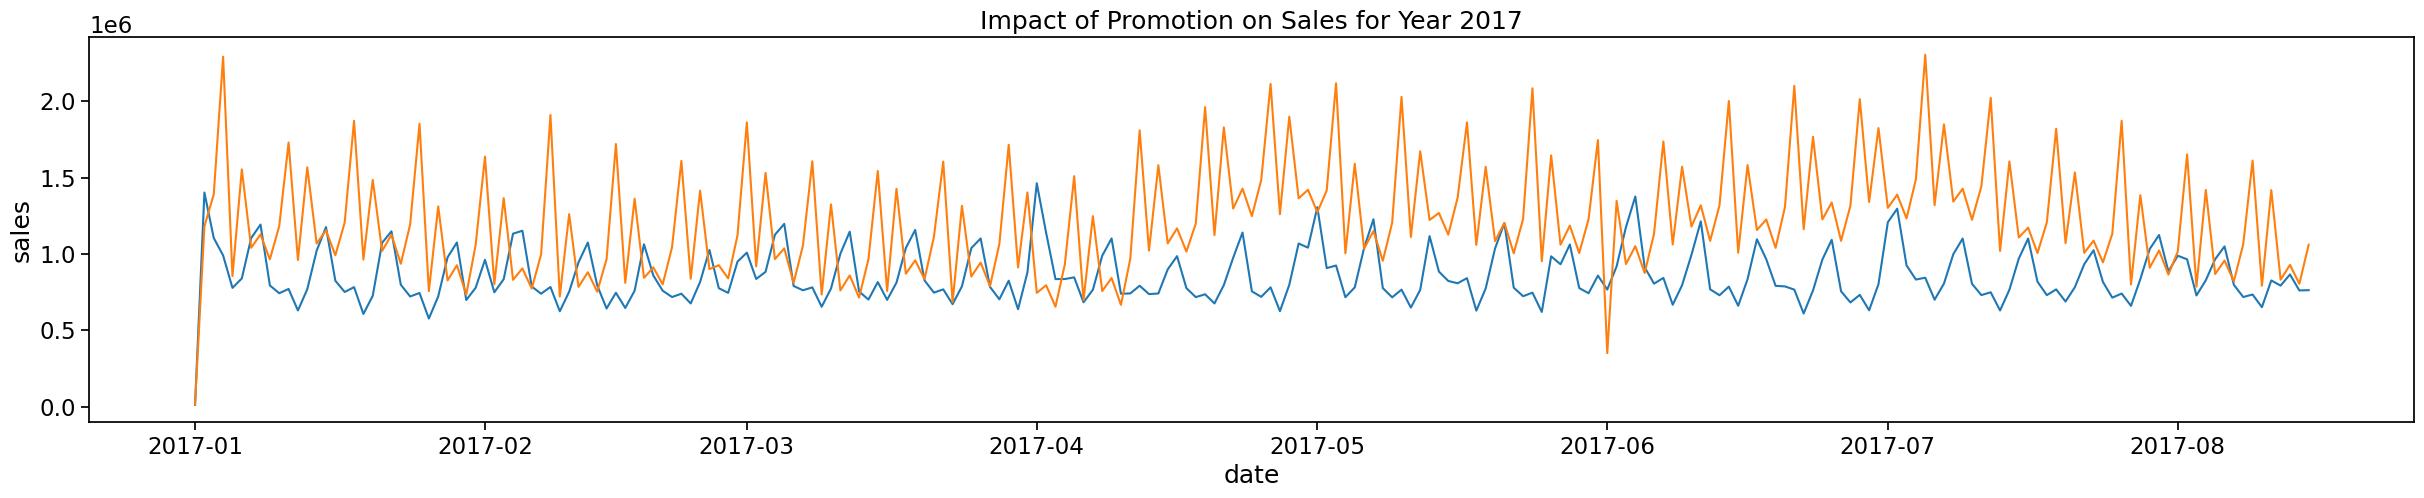

In [325]:
# Ploting impact of holidays on sales pover time
for year in train_merged.date.dt.year.unique():
    plt.figure(figsize=(30,5))
    df_daily_sales = train_merged[train_merged.date.dt.year == year].groupby(['date'])['sales'].sum()
    df_onpromotion = train_merged[train_merged.date.dt.year == year].groupby(['date'])['onpromotion'].sum()
    sns.lineplot(x=df_daily_sales.index, y=df_daily_sales)
    sns.lineplot(x=df_onpromotion.index, y=df_onpromotion*100)
    plt.title(f"Impact of Promotion on Sales for Year {year}")
    plt.show()

* We can clearly see that **onpromotion** has a positive effect on **sales**.

## 3. Data Cleaning

* Let's treat these missing values one by one.

In [326]:
train_merged.isna().sum()

date                   0
store_nbr              0
family                 0
sales                  0
onpromotion            0
city                   0
state                  0
type                   0
cluster                0
type_local             0
type_national          0
type_reg               0
dcoilwtico             0
is_national_holiday    0
dtype: int64

* There is no missing value in **train_merged** dataset, we can save this to a new file for further processing.

In [327]:
train_merged.to_csv('../../input/store_sales_time_series_forecasting/train_merged.csv', index=False)

In [328]:
test_merged.isna().sum()

id               0
date             0
store_nbr        0
family           0
onpromotion      0
city             0
state            0
type             0
cluster          0
type_local       0
type_national    0
type_reg         0
dcoilwtico       0
dtype: int64

In [329]:
test_merged.to_csv('../../input/store_sales_time_series_forecasting/test_merged.csv', index=False)

: 